In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pds
from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
from sklearn.decomposition import PCA, FactorAnalysis
from itertools import compress
import multiprocessing as mp
import time
import math
import seaborn as sn
from scipy.fft import fft
import glob
from datetime import date

In [2]:
aopy.utils.get_memory_available_gb()

658

# Set parameters

In [3]:
save_figs = False
base_save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/"
np_preproc_data_folder = 'np_analysis_preproc_data'
ecog_dec_acc_file_name = 'ecog_decoding_maps/npinsert_ecog_decoding_all'

subject = 'beignet'
align_events = ['TARGET ONSET', 'GO CUE', 'MOVEMENT ONSET']

In [4]:
# Decoding calculation parameters
tbefore = 0.5
tafter = 1
nlda_lags = 1
niter_match = 50
min_trial_prop = .85
ntrial_bin_size = 96
nfolds = 4

# Visualization parameters
colors = sn.color_palette(n_colors=9)
recording_brain_areas={'M1': [30, 56, 47, 40, 121, 48, 120, 98], 'PM':[11, 9, 18, 22, 10, 45]}
day_colors = ['dodgerblue', 'indigo', 'violet', 'lightblue', 'mediumorchid',
              'purple', 'steelblue', 'dodgerblue', 'lightblue', 'red', 'black', 'green', 'purple', 'cyan', 'gray', 'yellow'] 

In [5]:
plt.rcParams['xtick.labelsize']=24
plt.rcParams['ytick.labelsize']=24
plt.rcParams['axes.labelsize']=28
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.spines.right']=False
plt.rcParams['lines.linewidth']=5

In [6]:
def smooth_timeseries_gaus(timeseries_data, samplerate, width, nstd=3, conv_mode='same'):
    '''
    Smooths across 2 
    
    Args:
        timeseries_data (ntime, ...)
        samplerate (int): Sample rate of timeseries
        width (float): Width of the gaussian in time [ms] from -nstd to +nstd
        nstd (float/int): Number of standard deviations to be used in the filter calculation.
        conv_mode (str): Sets the size of the output. Takes eithe 'full', 'valid', or 'same'. See scipy.signal.convolve for full documentationat
        
    Returns: 
        smoothed_timeseries
    '''
    sample_std = (width/nstd)*(samplerate/(1000)) # Convert from s to ms
    x = np.arange(-sample_std*nstd, nstd*sample_std+1)
    gaus_filter = (1/(sample_std*np.sqrt(2*np.pi)))*np.exp(-(x**2)/(2*sample_std**2))
    return np.apply_along_axis(scipy.signal.convolve, 0, timeseries_data, gaus_filter, mode=conv_mode, method='direct')
def load_hdf_group(data_dir, hdf_filename, group="/"):
    '''
    Loads any datasets from the given hdf group into a dictionary. Also will
    recursively load other groups if any exist under the given group

    Args:
        data_dir (str): folder where data is located
        hdf_filename (str): name of hdf file
        group (str): name of the group to load
    
    Returns:
        dict: all the datasets contained in the given group
    '''
    full_file_name = os.path.join(data_dir, hdf_filename)
    hdf = h5py.File(full_file_name, 'r')
    if group not in hdf:
        raise ValueError('No such group in file {}'.format(hdf_filename))

    # Recursively load groups until datasets are reached
    def _load_hdf_group(hdf):
        keys = hdf.keys()
        data = dict()
        for k in keys:
            if isinstance(hdf[k], h5py.Group):
                data[k] = _load_hdf_group(hdf[k])
            else:
                k_, v = _load_hdf_dataset(hdf[k], k)
                data[k_] = v
        return data

    data = _load_hdf_group(hdf[group])
    hdf.close()
    return data

def _load_hdf_dataset(dataset, name):
    '''
    Internal function for loading hdf datasets. Decodes json and unicode data automatically.

    Args:
        dataset (hdf object): dataset to load
        name (str): name of the dataset

    Returns:
        tuple: Tuple containing:
            | **name (str):** name of the dataset (might be modified)
            | **data (object):** loaded data
    '''
    data = dataset[()]
    if '_json' in name:
        import json
        name = name.replace('_json', '')
        data = json.loads(data)
    try:
        data = data.decode('utf-8')
    except:
        pass
    return name, data

def get_rotations(data_in, condition_labels, separate_conditions=True, pcs=None):
    '''
    
    Args:
        data_in (ntime, nfeatures, ntrials):
        condition_labels (ntrials)
        separate_conditions (bool): to mean average at each time point
    
    Returns:
        tavg_proj_data (ntime, nfeat, ncond)
        indiv_proj_data (ntime, nfeat, ntrials)
        pca_components (nweights, nfeat)
        
    
    '''
    ntime, nfeat, ntrials = data_in.shape
    ncond = len(np.unique(condition_labels))
    
    if ntime*ncond < nfeat:
        print('You need more samples than features')
    
    # Zscore activity from each neuron.
    for ifeat in range(nfeat):
        data_in[:,ifeat,:] = scipy.stats.zscore(data_in[:,ifeat,:], axis=None) # Ensure activity has the same range for each channel
    
    # Trial average for each condition
    tavg_data = np.zeros((ntime,nfeat,ncond))
    for icond, cond in enumerate(np.unique(condition_labels)):
        tavg_data[:,:,icond] = np.mean(data_in[:,:,condition_labels==cond], axis=2)
    
    # Center at each time point for each channel across conditions
    if separate_conditions:
        cond_data = tavg_data - np.nanmean(tavg_data, axis=2)[:,:,None] # Center data across conditions
    else:
        cond_data = tavg_data
    
    # Concatenate data into the shape (ct X n)
    reorg_data = np.zeros((ntime*ncond, nfeat))
    for ifeat in range(nfeat):
        reorg_data[:,ifeat] = cond_data[:,ifeat,:].flatten()
    
    # Calculate PCs and fit to conditioned data
    print(reorg_data.shape)
    pca = PCA().fit(reorg_data)
    
    # Project data from each condition onto PCs
    tavg_proj_data = np.zeros((ntime, nfeat, ncond))*np.nan
    for itarget in range(ncond):
        tavg_proj_data[:,:,itarget] = pca.transform(cond_data[:,:,itarget])
        
    # Project data from each trial onto PCs
    indiv_proj_data = np.zeros((ntime, nfeat, ntrials))
    for itrial in range(ntrials):
        indiv_proj_data[:,:,itrial] = pca.transform(data_in[:,:,itrial])
    
    return tavg_proj_data, indiv_proj_data, pca.components_

import copy
def estimate_PR(data, ddof=1, sqrt_transform=False, normalize=False):
    '''
    This function calculates participation ratio for given data. Participation ratio counts the effective dimensions of the spread of data by taking the ratio of the square of the first and second moments of the eigenvalue probability density function. Refer: Recanatesi S, Dimensionality in recurrent spiking networks: Global trends in activity and local origins in connectivity. PLoS Comput Biol. 2019
    
      Args:
        data (2D Numpy array): Neural data in format (n_timepoints, n_units)
        ddof : (int) :Number of degrees of freedom to use when computing PR_norm (default: 1).
        sqrt_transform : (bool) : Whether to apply a square root transform to remove poisson dependence on spike count data before computing PR_norm (default: False).
        normalize bool : Whether to compute the normalized PR or the participation ratio itself(default: False)
      Returns:
          PR (float): dimensionality in terms of participation ratio, normalized to the number of units if normalize is True.
  '''
    n_time_bins, n_units = data.shape
    X = copy.copy(data)  # local copy, because data is mutable. for square root transform

    if sqrt_transform:
        X = np.sqrt(X + 0.375)  # see Kihlberg, 1972; 0.386 could also be a good value

    X = X - np.mean(X, axis=0, keepdims=True)  # center data
    C = 1. / (n_time_bins - ddof) * X.T @ X
    eigenvalues = np.linalg.eigvals(C)
    PR = (np.sum(eigenvalues)) ** 2 / np.sum(eigenvalues ** 2)

    return (PR - 1) / (X.shape[1] - 1) if normalize else PR

In [7]:
# Subspace angles
from sklearn.preprocessing import StandardScaler

def subspace_angles(A, B, angle_in_degrees = True):
    """Compute the subspace angles between two subspaces."""
    # Compute the Singular Value Decomposition (SVD) of A^T * B
    U, S, Vh = np.linalg.svd(np.dot(A.T, B))
    
    # Compute the principal angles from the singular values
    principal_angles = np.arccos(np.minimum(S, 1.0))
    mean_principal_angle = np.mean(principal_angles)
    
    return np.degrees(mean_principal_angle) if angle_in_degrees else mean_principal_angle 

from scipy.linalg import subspace_angles

def orientation_similarity(subspace1, subspace2):
    """Compute orientation similarity between two subspaces. Value ranges from 0 to 1.
     Identical subspace will have Sori = 1, while orthogonal spaces will have Sori = 0.
     """
    # Calculate principal angles between subspaces
    angles = subspace_angles(subspace1, subspace2)
    # print(angles)

    # Calculate the mean cosine of these angles
    similarity = np.mean(np.cos(angles))
    # print(np.cos(angles))

    return similarity


def get_PCA_subspace(data): 
    """
    Compute the principal component subspace of the given data.
    
    Parameters:
    data (numpy.ndarray): Input data array with shape (n_samples, n_features).
    
    Returns:
    numpy.ndarray: The principal component subspace with shape (n_features, n_components),
                   where n_components is the number of principal components.
    """


    X = data - np.mean(data, axis = 0)

    # Create a PCA instance and fit to the data
    pca = PCA()  # Here, we are getting all components, but you can specify fewer if desired.
    pca.fit_transform(X)

    # Extract the subspace
    subspace = pca.components_.T 

    return subspace


# Load relevant data

In [8]:
print(os.path.join(base_save_dir, ecog_dec_acc_file_name))
ecog_dec_acc_file_name = 'ecog_decoding_maps/npinsert_ecog_decoding'
ecog_dec_acc_file_name_x = 'ecog_decoding_maps/npinsert_ecog_decoding_x'
ecog_dec_acc_file_name_y = 'ecog_decoding_maps/npinsert_ecog_decoding_y'
ecog_dec_acc = load_hdf_group(base_save_dir, ecog_dec_acc_file_name)
ecog_dec_acc_x = load_hdf_group(base_save_dir, ecog_dec_acc_file_name_x)
ecog_dec_acc_y = load_hdf_group(base_save_dir, ecog_dec_acc_file_name_y)
day_colors = ecog_dec_acc[subject]['day_colors']

/media/moor-data/results/Ryan/neuropixel_targeting/ecog_decoding_maps/npinsert_ecog_decoding_all


## Load preprocessed neuropixel data

In [10]:
start = time.time()
aopy.utils.release_memory_limit()
df, rasters, preproc_metadata = aopy.data.base.pkl_read(f"{subject}_np_preprocessed", os.path.join(base_save_dir, np_preproc_data_folder))
print(f"{np.round((time.time()-start)/60)} min to load preprocessed data")
nrecs = preproc_metadata['nrecs']
recording_site = preproc_metadata['recording_sites'] # will be the same for all align events
implants = ['NPinsert72' if preproc_metadata['implant'][irec] == 'NP_Insert72' else 'NPinsert137' for irec in range(len(preproc_metadata['implant']))] #Rename because name in bmi3d is slightly different (TODO)
dates = np.unique(df['date'])

4.0 min to load preprocessed data


## Load ECoG decoding accuracy

In [11]:
random_units, column_units, depth_units, depth_group_info_by_site, pseudopopulation_metadata, unit_df = aopy.data.base.pkl_read(f"{subject}_np_psuedopopulations",  os.path.join(base_save_dir, np_preproc_data_folder))

In [12]:
save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/np_analysis_preproc_data"
np_decoding, _ = aopy.data.base.pkl_read(f"{subject}_np_decoding_accuracy", save_dir)
max_np_decoding = [np.max(np.mean(np_decoding[irec], axis=1)) for irec in range(len(np_decoding))]

In [13]:
# define ecog decoding accuracy as one variable to make it easier to do further analysis
pp_column_sites = [column_units[igroup]['rec_site'][0] for igroup in range(len(column_units))]
pp_column_implants = [column_units[igroup]['implant'][0] for igroup in range(len(column_units))]
ecog_dec_acc_rec_site, ecog_dec_acc_rec_site_pp = {}, {}
ecog_dec_acc_rec_site_x = {}
ecog_dec_acc_rec_site_y = {}
for align_event in align_events:
    ecog_dec_acc_rec_site[align_event] = [ecog_dec_acc[subject][f"{implants[irec]}_interp"][rec_site-1] for irec, rec_site in enumerate(recording_site)]
    ecog_dec_acc_rec_site_pp[align_event] = [ecog_dec_acc[subject][f"{pp_column_implants[irec]}_interp"][rec_site-1] for irec, rec_site in enumerate(pp_column_sites)]
    ecog_dec_acc_rec_site_x[align_event] = [ecog_dec_acc_x[subject][f"{implants[irec]}_interp"][rec_site-1] for irec, rec_site in enumerate(recording_site)]
    ecog_dec_acc_rec_site_y[align_event] = [ecog_dec_acc_y[subject][f"{implants[irec]}_interp"][rec_site-1] for irec, rec_site in enumerate(recording_site)]

## Identify stable units

In [14]:
if subject == 'beignet':
    qc_results, ksdrift = aopy.data.base.pkl_read(f"{subject}_QCunits", os.path.join(base_save_dir, np_preproc_data_folder))
elif subject == 'affi':
    qc_results = aopy.data.base.pkl_read(f"{subject}_QCunits", os.path.join(base_save_dir, np_preproc_data_folder))
stable_unit_labels = [qc_results['final_good_unit_labels'][irec] for irec in range(nrecs)]
stable_unit_idx = [qc_results['final_good_unit_idx'][irec] for irec in range(nrecs)]
nstable_unit = np.array([len(qc_results['final_good_unit_idx'][irec]) for irec in range(nrecs)])
neuron_pos = [qc_results['position'][irec] for irec in range(nrecs)]

# stable_unit_labels = [qc_results['manual_good_unit_labels'][irec] for irec in range(nrecs)]
# stable_unit_idx = [qc_results['manual_good_unit_idx'][irec] for irec in range(nrecs)]
# nstable_unit = np.array([len(qc_results['manual_good_unit_idx'][irec]) for irec in range(nrecs)])
# neuron_pos = [qc_results['manual_position'][irec] for irec in range(nrecs)]

## Zscore FR

In [15]:
# Zscore the activity of each neuron (even unstable) across all trials
frs = {}
fr_zscore = {}
new_bin_fs = 50
fr_stats = {'mean_fr': {}, 'var_fr': {}, 'mean_fr_sqrt': {}, 'var_fr_sqrt': {}}
for align_event in tqdm(align_events):
    temp_spike_data = [rasters['neural'][align_event][irec][:,np.array(df['good_trial'][df['date']==dates[irec]]),:][:,:,stable_unit_idx[irec]] for irec in range(nrecs)] # Shape (ntime, ntrial, nunit)    
    # temp_spike_data = [rasters['sbp'][align_event][irec][:,np.array(df['good_trial'][df['date']==dates[irec]]),:] for irec in range(nrecs)] # Shape (ntime, ntrial, nunit)    
    fr_stats['mean_fr'][align_event] = []
    fr_stats['var_fr'][align_event] = []
    fr_stats['mean_fr_sqrt'][align_event] = []
    fr_stats['var_fr_sqrt'][align_event] = []
    fr_stats['mean_fr'][align_event].extend([np.mean(temp_spike_data[irec], axis=(0,1)) for irec in range(nrecs)])
    fr_stats['var_fr'][align_event].extend([np.var(temp_spike_data[irec], axis=(0,1)) for irec in range(nrecs)])
    fr_stats['mean_fr_sqrt'][align_event].extend([np.mean(np.sqrt(temp_spike_data[irec]+.375), axis=(0,1)) for irec in range(nrecs)])
    fr_stats['var_fr_sqrt'][align_event].extend([np.var(np.sqrt(temp_spike_data[irec]+.375), axis=(0,1)) for irec in range(nrecs)])
    
    frs[align_event] = {'align_spikes': [], 'align_spikes_dwns': []}
    fr_zscore[align_event] = {'align_spikes_zscore': [], 'align_spikes_zscore_dwns': []}
    [fr_zscore[align_event]['align_spikes_zscore'].append((temp_spike_data[irec]-np.mean(temp_spike_data[irec], axis=(0,1)))/np.std(temp_spike_data[irec], axis=(0,1))) for irec in range(nrecs)]
    [frs[align_event]['align_spikes'].append(temp_spike_data[irec]) for irec in range(nrecs)]

    for irec in range(nrecs):
        temp_resampled_spike_data = aopy.precondition.base.downsample(temp_spike_data[irec], preproc_metadata['neural_samplerate'], new_bin_fs)
        frs[align_event]['align_spikes_dwns'].append(temp_resampled_spike_data)
        fr_zscore[align_event]['align_spikes_zscore_dwns'].append((temp_resampled_spike_data-np.mean(temp_resampled_spike_data, axis=(0,1)))/np.std(temp_resampled_spike_data, axis=(0,1)))

  0%|          | 0/3 [00:00<?, ?it/s]

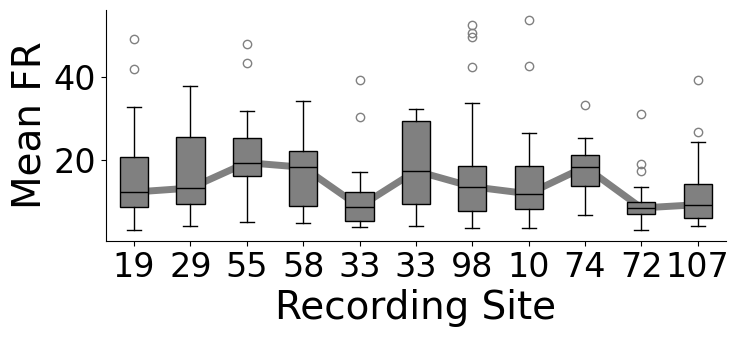

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
aopy.visualization.plot_boxplots(fr_stats['mean_fr'][align_events[-1]], np.arange(nrecs), ax = ax)
ax.set(xlabel='Recording Site', ylabel='Mean FR')
ax.set_xticks(np.arange(nrecs), recording_site)
plt.show()

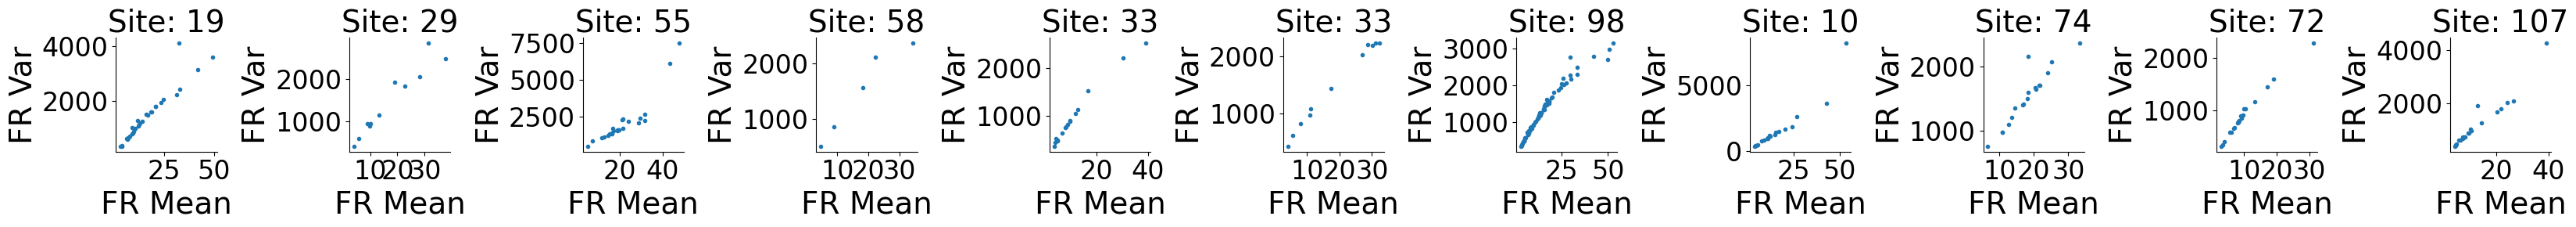

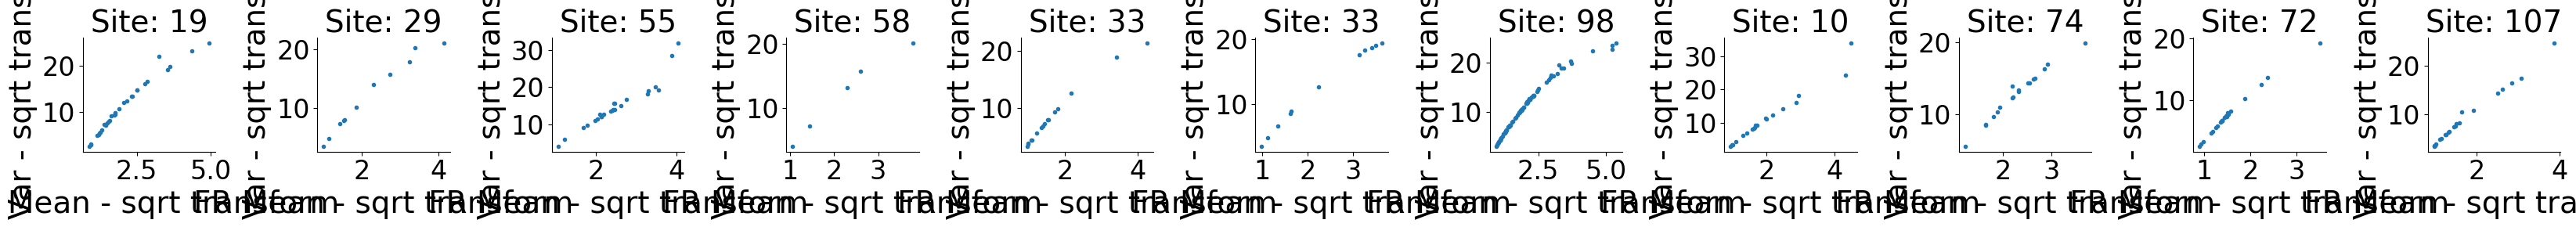

In [17]:
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*3, 3))
for irec in range(nrecs):
    ax[irec].plot(fr_stats['mean_fr'][align_events[-1]][irec], fr_stats['var_fr'][align_events[-1]][irec], '.')
    ax[irec].set(xlabel='FR Mean', ylabel='FR Var', title=f"Site: {recording_site[irec]}")
    
fig.tight_layout()
plt.show()

# Neural data with sqrt transform applied
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*3, 3))
for irec in range(nrecs):
    ax[irec].plot(fr_stats['mean_fr_sqrt'][align_events[-1]][irec], fr_stats['var_fr_sqrt'][align_events[-1]][irec], '.')
    ax[irec].set(xlabel='FR Mean - sqrt transform', ylabel='FR Var - sqrt transform', title=f"Site: {recording_site[irec]}")
    
fig.tight_layout()
plt.show()

# Calculate dynamics

In [18]:
np_pop_dynamics = {}

In [19]:
# Concatenate spike data for across all trials for each recording
new_bin_fs = 20
conc_spikes, conc_spikes_dwns, conc_spikes_smooth, conc_spikes_dwns_smooth = [], [], [], []
conc_spikes_trial_sep = []
zconc_spikes_trial_sep = []
zconc_spikes, zconc_spikes_dwns, zconc_spikes_dwns_smooth = [], [], []
zconc_spikes_smooth = []
for idate, date in enumerate(tqdm(dates[:])):    
    conc_spikes_day = []
    conc_spikes_day_smooth = []
    temp_spike_segs = list(df['spike_segs'][df[(df['date']==date)*(df['good_trial'])].index])   
    for itrial in range(len(temp_spike_segs)):
        temp_spike_labels = list(temp_spike_segs[itrial].keys())
        temp_ntime = len(temp_spike_segs[itrial][temp_spike_labels[0]]) # For each trial the spike segments are the same length
        trial_binned_spikes = np.zeros((temp_ntime, len(temp_spike_labels)))*np.nan
        for ilabel, label in enumerate(temp_spike_labels):
            trial_binned_spikes[:,ilabel] = temp_spike_segs[itrial][label]
        
        conc_spikes_day.append(trial_binned_spikes)

# for idate, date in enumerate(tqdm(dates[:])):    
#     conc_spikes_day = []
#     conc_spikes_day_smooth = []
#     temp_spike_segs = list(df['ap_band_power_segs'][df[(df['date']==date)*(df['good_trial'])].index])
#     for itrial in range(len(temp_spike_segs)):
#         # temp_spike_labels = np.arange(temp_spike_segs[itrial].shape[1])
#         # temp_ntime = temp_spike_segs[itrial].shape[0] # For each trial, the spike segments for each unit are the same length
#         # trial_binned_spikes = np.zeros((temp_ntime, len(temp_spike_labels)))*np.nan
#         # for ilabel in temp_spike_labels:
#         #     trial_binned_spikes[:,ilabel] = temp_spike_segs[itrial][label]
        
#         conc_spikes_day.append(temp_spike_segs[itrial])
        
    conc_spikes.append(np.concatenate(conc_spikes_day))
    conc_spikes_dwns.append(aopy.precondition.base.downsample(np.concatenate(conc_spikes_day), preproc_metadata['neural_samplerate'], new_bin_fs))
    conc_spikes_smooth.append(smooth_timeseries_gaus(np.concatenate(conc_spikes_day), 1/preproc_metadata['spike_bin_width'], 300))
    conc_spikes_dwns_smooth.append(smooth_timeseries_gaus(aopy.precondition.base.downsample(np.concatenate(conc_spikes_day), preproc_metadata['neural_samplerate'], new_bin_fs), 1/preproc_metadata['spike_bin_width'], 300))
    conc_spikes_trial_sep.append(conc_spikes_day)
    zconc_spikes_trial_sep.append([(conc_spikes_day[itr] - np.mean(np.concatenate(conc_spikes_day), axis=0))/np.std(np.concatenate(conc_spikes_day), axis=0) for itr in range(len(conc_spikes_day))])
    temp_zconc = (np.concatenate(conc_spikes_day) - np.mean(np.concatenate(conc_spikes_day), axis=0))/np.std(np.concatenate(conc_spikes_day), axis=0)
    temp_zconc_dwns = (aopy.precondition.base.downsample(np.concatenate(conc_spikes_day), preproc_metadata['neural_samplerate'], new_bin_fs) - np.mean(aopy.precondition.base.downsample(np.concatenate(conc_spikes_day), preproc_metadata['neural_samplerate'], new_bin_fs), axis=0))/np.std(aopy.precondition.base.downsample(np.concatenate(conc_spikes_day), preproc_metadata['neural_samplerate'], new_bin_fs), axis=0)
    zconc_spikes.append(temp_zconc)
    zconc_spikes_dwns.append(temp_zconc_dwns)
    zconc_spikes_smooth.append(smooth_timeseries_gaus(temp_zconc, 1/preproc_metadata['spike_bin_width'], 150))
    zconc_spikes_dwns_smooth.append(smooth_timeseries_gaus(temp_zconc_dwns, new_bin_fs, 300))

  0%|          | 0/11 [00:00<?, ?it/s]

/tmp/ipykernel_1174400/2085773552.py:39: RuntimeWarning: invalid value encountered in divide
  zconc_spikes_trial_sep.append([(conc_spikes_day[itr] - np.mean(np.concatenate(conc_spikes_day), axis=0))/np.std(np.concatenate(conc_spikes_day), axis=0) for itr in range(len(conc_spikes_day))])
/tmp/ipykernel_1174400/2085773552.py:40: RuntimeWarning: invalid value encountered in divide
  temp_zconc = (np.concatenate(conc_spikes_day) - np.mean(np.concatenate(conc_spikes_day), axis=0))/np.std(np.concatenate(conc_spikes_day), axis=0)
/tmp/ipykernel_1174400/2085773552.py:41: RuntimeWarning: invalid value encountered in divide
  temp_zconc_dwns = (aopy.precondition.base.downsample(np.concatenate(conc_spikes_day), preproc_metadata['neural_samplerate'], new_bin_fs) - np.mean(aopy.precondition.base.downsample(np.concatenate(conc_spikes_day), preproc_metadata['neural_samplerate'], new_bin_fs), axis=0))/np.std(aopy.precondition.base.downsample(np.concatenate(conc_spikes_day), preproc_metadata['neural_s

## Dimensionality

In [20]:
np_pop_dynamics['dimensionality']={}
np_pop_dynamics['dimensionality']['PR'], np_pop_dynamics['dimensionality']['PR_norm'] = [], []
np_pop_dynamics['dimensionality']['PCA_exp_var'], np_pop_dynamics['dimensionality']['PCA_ndims'], np_pop_dynamics['dimensionality']['PCA_ndims_norm'] = [], [], []
for idate, date, in enumerate(tqdm(dates)):
    # Participation Ratio
    np_pop_dynamics['dimensionality']['PR'].append(estimate_PR(conc_spikes_dwns_smooth[idate][:,stable_unit_idx[idate]], sqrt_transform=True))
    np_pop_dynamics['dimensionality']['PR_norm'].append(estimate_PR(conc_spikes_dwns_smooth[idate][:,stable_unit_idx[idate]], normalize=True, sqrt_transform=True))

    # PCA
    exp_var, ndims, _ = aopy.analysis.get_pca_dimensions(np.sqrt(conc_spikes_dwns_smooth[idate][:,stable_unit_idx[idate]] + 0.375))
    np_pop_dynamics['dimensionality']['PCA_exp_var'].append(np.array(exp_var))
    np_pop_dynamics['dimensionality']['PCA_ndims'].append(ndims)
    np_pop_dynamics['dimensionality']['PCA_ndims_norm'].append((ndims - 1) / (conc_spikes_dwns_smooth[idate].shape[1] - 1))

# Use rasters aligned to specific task events
for align_event in align_events:
    np_pop_dynamics['dimensionality'][align_event] = {}
    np_pop_dynamics['dimensionality'][align_event]['PR'] = []
    np_pop_dynamics['dimensionality'][align_event]['PR_norm'] = []
    np_pop_dynamics['dimensionality'][align_event]['PCA_exp_var'] = []
    np_pop_dynamics['dimensionality'][align_event]['PCA_ndims'] = []
    for idate, date, in enumerate(tqdm(dates)):
        # Participation Ratio
        np_pop_dynamics['dimensionality'][align_event]['PR'].append(estimate_PR(np.vstack(fr_zscore[align_event]['align_spikes_zscore'][idate])))
        np_pop_dynamics['dimensionality'][align_event]['PR_norm'].append(estimate_PR(np.vstack(fr_zscore[align_event]['align_spikes_zscore'][idate]), normalize=True))

        # PCA
        exp_var, ndims, _ = aopy.analysis.get_pca_dimensions(np.vstack(fr_zscore[align_event]['align_spikes_zscore'][idate]))
        np_pop_dynamics['dimensionality'][align_event]['PCA_exp_var'].append(np.array(exp_var))
        np_pop_dynamics['dimensionality'][align_event]['PCA_ndims'].append(ndims)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

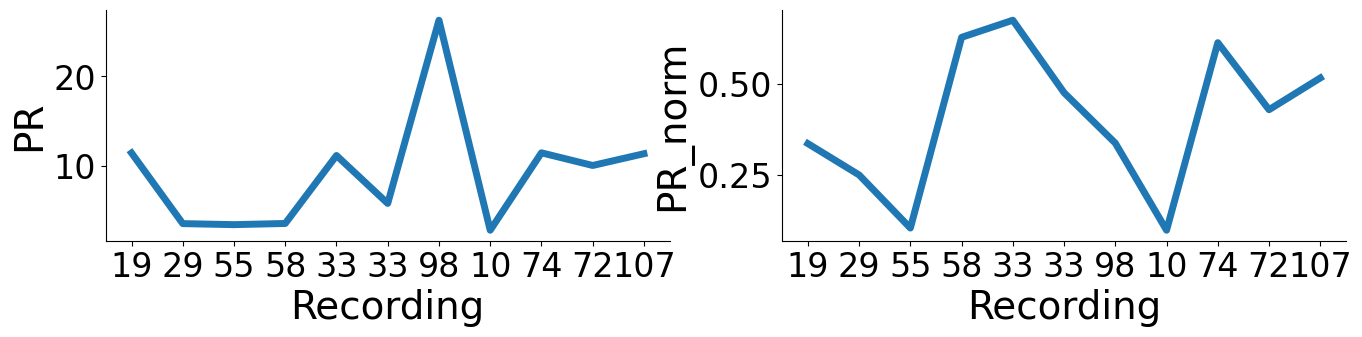

In [21]:
fig, ax = plt.subplots(1,2,figsize=(16,3)) # All spikes - want to also use data aligned to behavior.
ax[0].plot(np_pop_dynamics['dimensionality']['PR'])
ax[1].plot(np_pop_dynamics['dimensionality']['PR_norm'])
[ax[ia].set_xticks(np.arange(len(recording_site)), recording_site) for ia in range(len(ax))]
ax[0].set(xlabel='Recording', ylabel='PR')
ax[1].set(xlabel='Recording', ylabel='PR_norm')
plt.show()

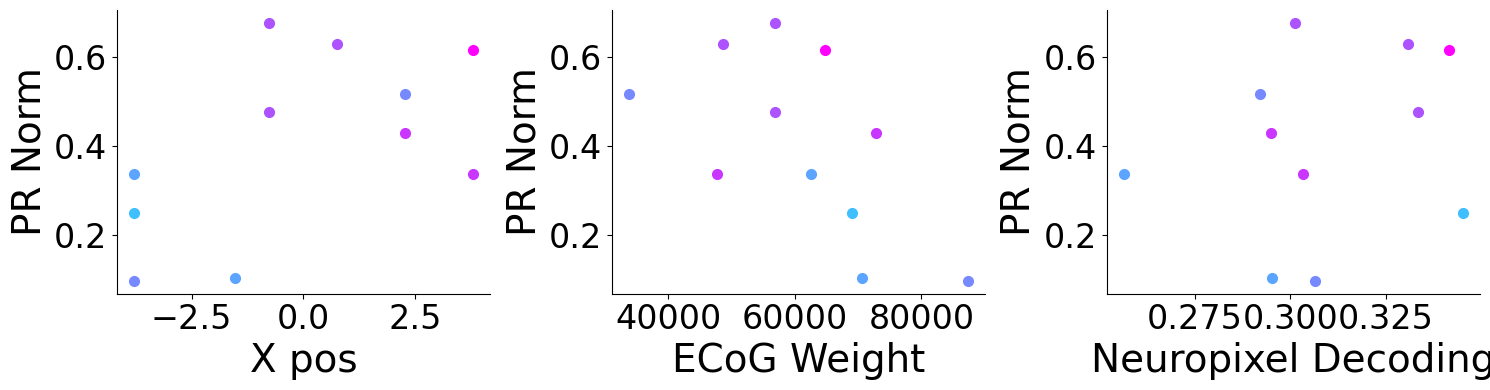

In [22]:
fig, ax = plt.subplots(1,3,figsize=(15,4)) # All spikes - want to also use data aligned to behavior.
# [ax[0].plot(0, np_pop_dynamics['dimensionality']['PR_norm'][irec], '.', color=day_colors[irec], markersize=14) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
# [ax[0].plot(1, np_pop_dynamics['dimensionality']['PR_norm'][irec], '.',color=day_colors[irec], markersize=14) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
[ax[0].plot(ecog_dec_acc[subject]['rec_locations'][irec,0], np_pop_dynamics['dimensionality']['PR_norm'][irec], '.',color=day_colors[irec], markersize=14) for irec in range(nrecs)]
ax[0].set(xlabel='X pos', ylabel='PR Norm')

[ax[1].plot(ecog_dec_acc_rec_site[align_events[-1]][irec], np_pop_dynamics['dimensionality']['PR_norm'][irec], '.', markersize=14, color=day_colors[irec]) for irec in range(nrecs)]
ax[1].set(xlabel='ECoG Weight', ylabel='PR Norm')

[ax[2].plot(max_np_decoding[irec], np_pop_dynamics['dimensionality']['PR_norm'][irec], '.', markersize=14, color=day_colors[irec]) for irec in range(nrecs)]
ax[2].set(xlabel='Neuropixel Decoding', ylabel='PR Norm')
fig.tight_layout()
plt.show()

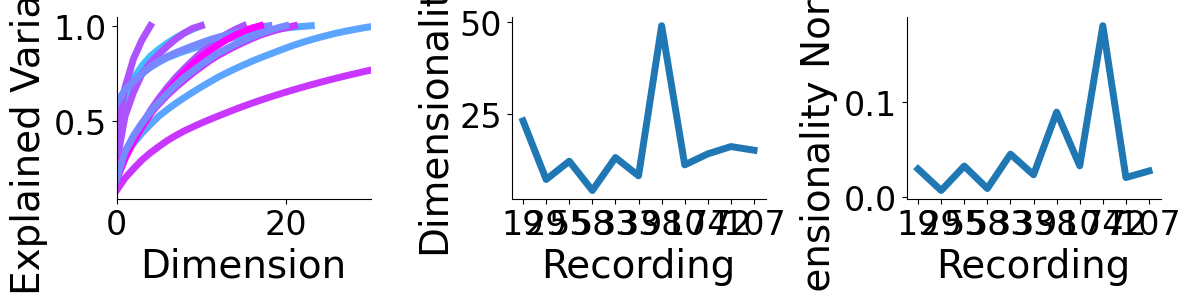

In [23]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
[ax[0].plot(np.cumsum(np_pop_dynamics['dimensionality']['PCA_exp_var'][idate])/np.sum(np_pop_dynamics['dimensionality']['PCA_exp_var'][idate]), color=day_colors[idate]) for idate in range(len(dates))]
ax[0].set(xlim=(0,30))
ax[0].set(xlabel='Dimension', ylabel='Explained Variance')

ax[1].plot(np_pop_dynamics['dimensionality']['PCA_ndims'])
ax[1].set_xticks(np.arange(len(recording_site)), recording_site)
ax[1].set(xlabel='Recording', ylabel='Dimensionality')
ax[2].plot(np_pop_dynamics['dimensionality']['PCA_ndims_norm'])
ax[2].set_xticks(np.arange(len(recording_site)), recording_site)
ax[2].set(xlabel='Recording', ylabel='Dimensionality Normalized')

fig.tight_layout()
plt.show()

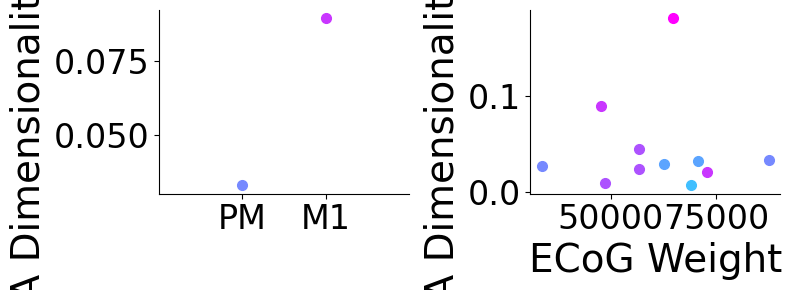

In [24]:
fig, ax = plt.subplots(1,2,figsize=(8,3)) # All spikes - want to also use data aligned to behavior.
[ax[0].plot(0, np_pop_dynamics['dimensionality']['PCA_ndims_norm'][irec], '.', color=day_colors[irec], markersize=14) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
[ax[0].plot(1, np_pop_dynamics['dimensionality']['PCA_ndims_norm'][irec], '.',color=day_colors[irec], markersize=14) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
# [ax[ia].set_xticks(np.arange(len(recording_site)), recording_site) for ia in range(len(ax))]
ax[0].set(ylabel='PCA Dimensionality Norm', xlim=(-1,2))
ax[0].set_xticks([0,1], ['PM', 'M1'])

[ax[1].plot(ecog_dec_acc_rec_site[align_events[-1]][irec], np_pop_dynamics['dimensionality']['PCA_ndims_norm'][irec], '.', markersize=14, color=day_colors[irec]) for irec in range(nrecs)]
ax[1].set(xlabel='ECoG Weight', ylabel='PCA Dimensionality Norm')
fig.tight_layout()
plt.show()

## Rotations

### Trial Averaged

In [25]:
align_event = align_events[-1]
print(align_event)
rotations = []
for irec in tqdm(range(nrecs)):
    temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
    temp_rotations = get_rotations(np.swapaxes(fr_zscore[align_event]['align_spikes_zscore_dwns'][irec], 1, 2), temp_target_labels)
    rotations.append(temp_rotations)

MOVEMENT ONSET


  0%|          | 0/11 [00:00<?, ?it/s]

(400, 32)
(400, 11)
(400, 24)
(400, 5)
(400, 16)
(400, 11)
(400, 76)
(400, 19)
(400, 18)
(400, 22)
(400, 21)


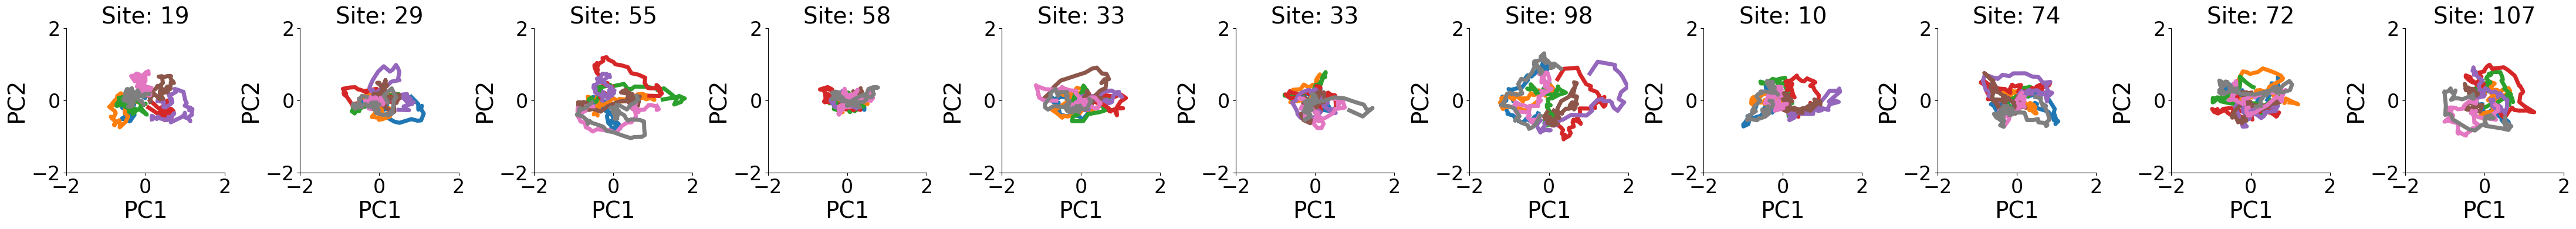

In [26]:
smooth_width = 100 #[ms]
# Projection onto PC1, PC2
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,4))
for irec in range(nrecs):
    [ax[irec].plot(smooth_timeseries_gaus(rotations[irec][0][:,0,icond], new_bin_fs, smooth_width), smooth_timeseries_gaus(rotations[irec][0][:,1,icond], new_bin_fs, smooth_width), color=colors[icond]) for icond in range(rotations[irec][0].shape[2])]
    ax[irec].set(xlim = (-2,2), ylim=(-2,2), xlabel='PC1', ylabel='PC2', title=f"Site: {recording_site[irec]}")
fig.tight_layout()
plt.show()

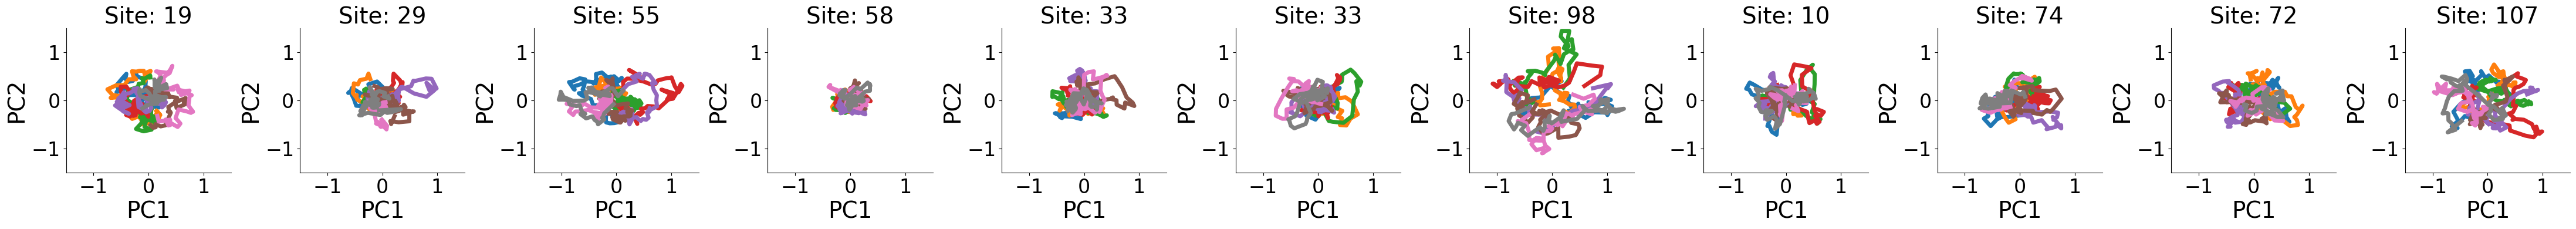

In [27]:
# Projection onto PC2, PC3
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,4))
for irec in range(nrecs):
    [ax[irec].plot(smooth_timeseries_gaus(rotations[irec][0][:,1,icond], new_bin_fs, smooth_width), smooth_timeseries_gaus(rotations[irec][0][:,2,icond], new_bin_fs, smooth_width), color=colors[icond]) for icond in range(rotations[irec][0].shape[2])]
    ax[irec].set(xlim = (-1.5,1.5), ylim=(-1.5,1.5), xlabel='PC1', ylabel='PC2', title=f"Site: {recording_site[irec]}")
fig.tight_layout()
plt.show()

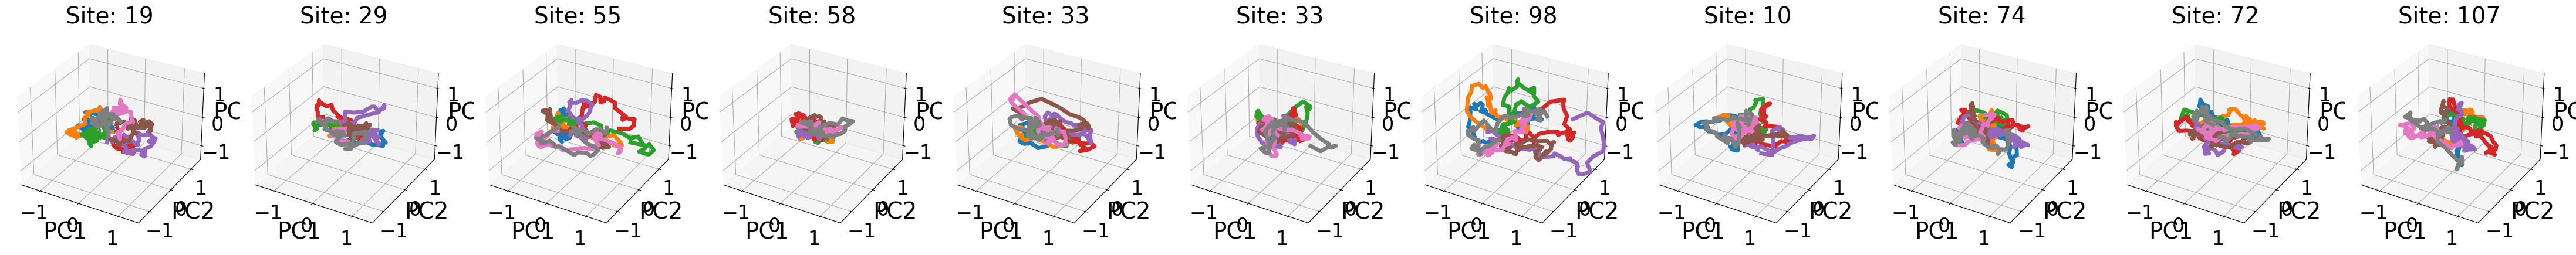

In [28]:
# Projection onto PC1, PC2, PC3
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,4), subplot_kw={'projection':'3d'})
for irec in range(nrecs):
    [ax[irec].plot(smooth_timeseries_gaus(rotations[irec][0][:,0,icond], new_bin_fs, smooth_width), smooth_timeseries_gaus(rotations[irec][0][:,1,icond], new_bin_fs, smooth_width),smooth_timeseries_gaus(rotations[irec][0][:,2,icond], new_bin_fs, smooth_width), color=colors[icond]) for icond in range(rotations[irec][0].shape[2])]
    ax[irec].set(xlim = (-1.5,1.5), ylim=(-1.5,1.5),zlim=(-1.5,1.5), xlabel='PC1', ylabel='PC2',zlabel='PC3', title=f"Site: {recording_site[irec]}")
fig.tight_layout()
plt.show()

### Single trial

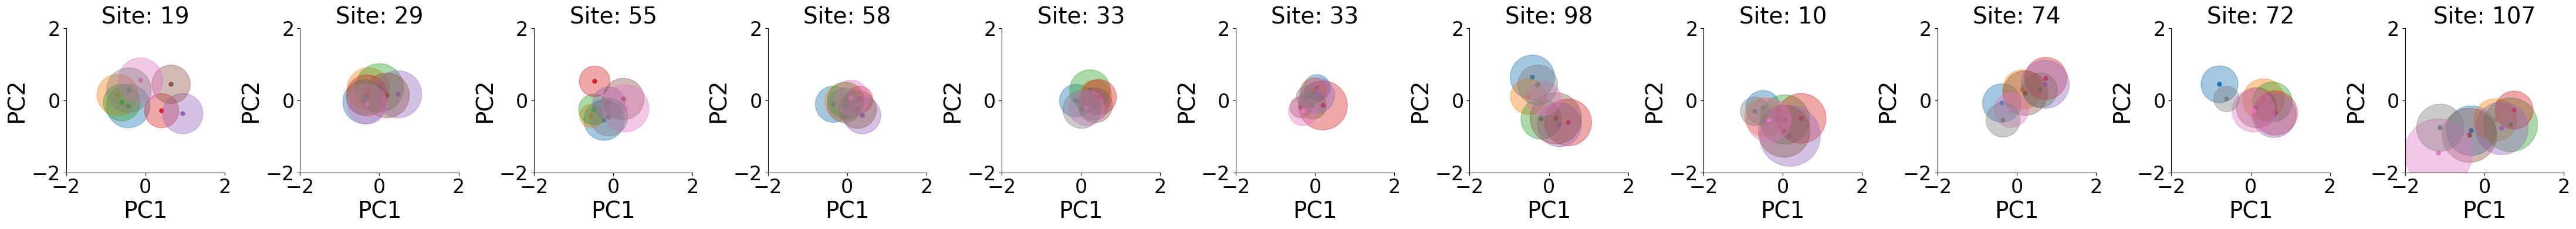

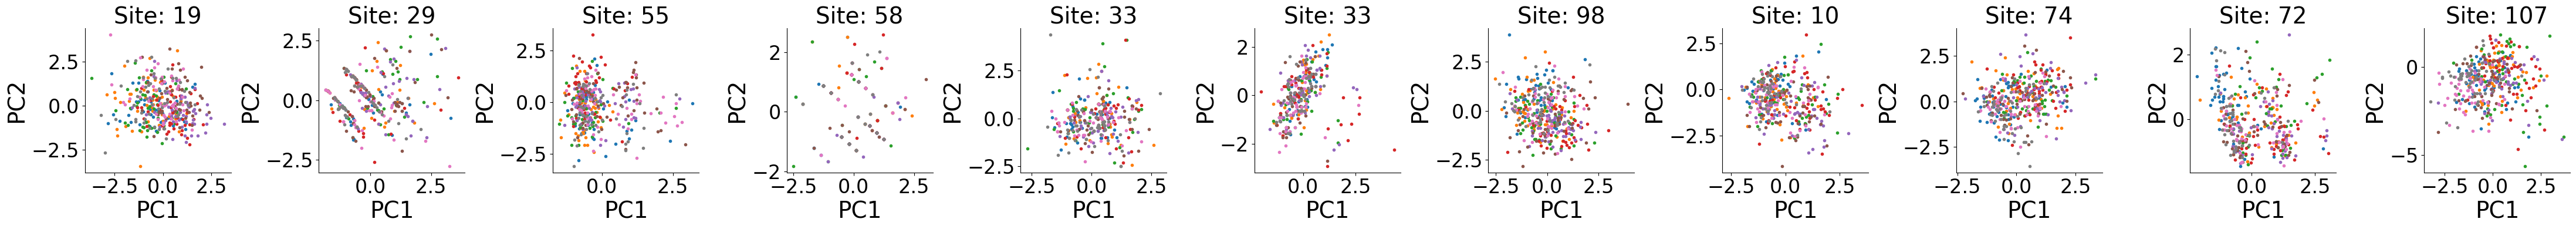

In [29]:
tidx = 30
unique_targets = np.unique(df['target_idx'])
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,4))
for irec in range(nrecs):
    temp_target_labels = np.array(df['target_idx'][(df['date']==dates[irec])*df['good_trial']])
    for itarg, targ in enumerate(unique_targets):
        temp_std = np.sqrt(np.std(rotations[irec][1][tidx,0,(temp_target_labels==targ)])**2 + np.mean(rotations[irec][1][tidx,1,(temp_target_labels==targ)])**2) 
        ax[irec].plot(np.mean(rotations[irec][1][tidx,0,(temp_target_labels==targ)]), np.mean(rotations[irec][1][tidx,1,(temp_target_labels==targ)]), '.', color=colors[itarg], markersize=10)
        ax[irec].plot(np.mean(rotations[irec][1][tidx,0,(temp_target_labels==targ)]), np.mean(rotations[irec][1][tidx,1,(temp_target_labels==targ)]), '.', color=colors[itarg], markersize=100*temp_std, alpha=0.4)
        ax[irec].set(xlim = (-2,2), ylim=(-2,2), xlabel='PC1', ylabel='PC2', title=f"Site: {recording_site[irec]}")
        ax[irec].set(xlabel='PC1', ylabel='PC2', title=f"Site: {recording_site[irec]}")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,4))
for irec in range(nrecs):
    temp_target_labels = np.array(df['target_idx'][(df['date']==dates[irec])*df['good_trial']])
    for itarg, targ in enumerate(unique_targets):
        ax[irec].plot(rotations[irec][1][tidx,0,(temp_target_labels==targ)], rotations[irec][1][tidx,1,(temp_target_labels==targ)], '.', color=colors[itarg])
    # ax[irec].set(xlim = (-3,3), ylim=(-3,3), xlabel='PC1', ylabel='PC2', title=f"Site: {recording_site[irec]}")
        ax[irec].set(xlabel='PC1', ylabel='PC2', title=f"Site: {recording_site[irec]}")
fig.tight_layout()
plt.show()

### Concatenated data

In [30]:
# Fit data on full concatenated spiking data
zconc_pca = []
for irec in tqdm(range(nrecs)):
    zconc_pca.append(PCA().fit(zconc_spikes_smooth[irec][:,stable_unit_idx[irec]]))

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

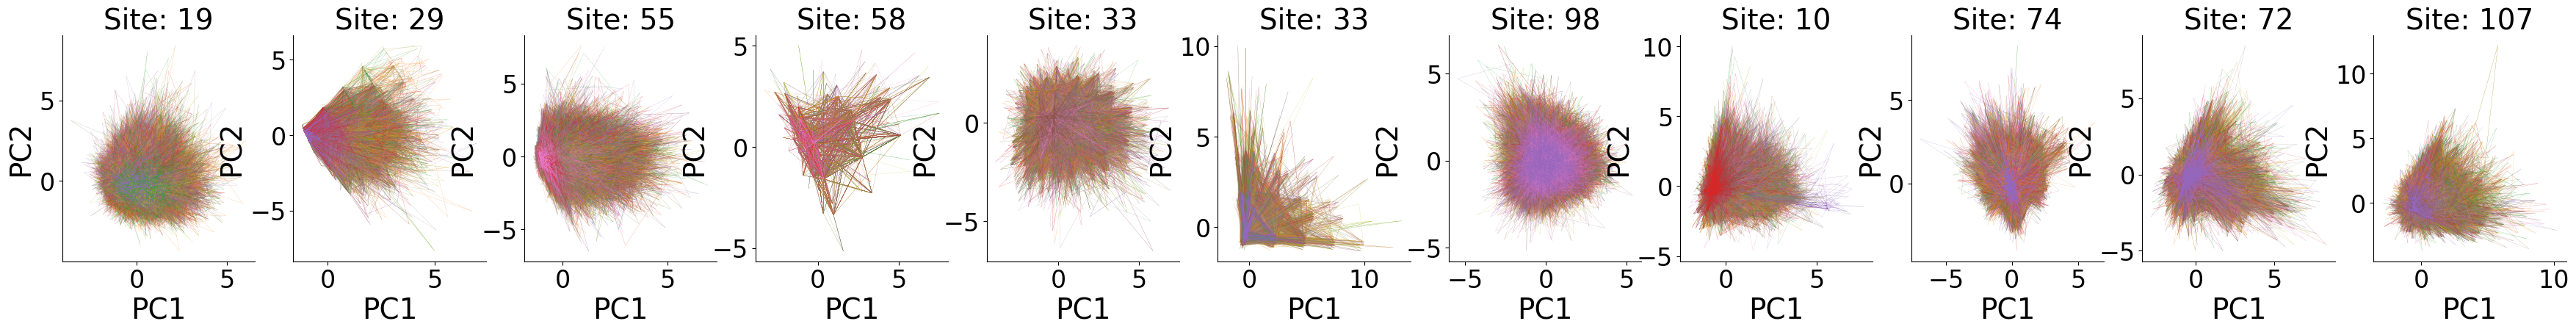

In [31]:
# Plot all full single trial trajectories
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,4))
for irec in tqdm(range(nrecs)):
    temp_target_labels = np.array(df['target_idx'][(df['date']==dates[irec])*df['good_trial']])
    for itrial in range(len(temp_target_labels)):
        temp_proj_trial = zconc_pca[irec].transform(zconc_spikes_trial_sep[irec][itrial][:,stable_unit_idx[irec]])
        ax[irec].plot(temp_proj_trial[:,0], temp_proj_trial[:,1], color=colors[temp_target_labels[itrial]], linewidth=0.1)
        ax[irec].set(xlabel='PC1', ylabel='PC2', title=f"Site: {recording_site[irec]}")

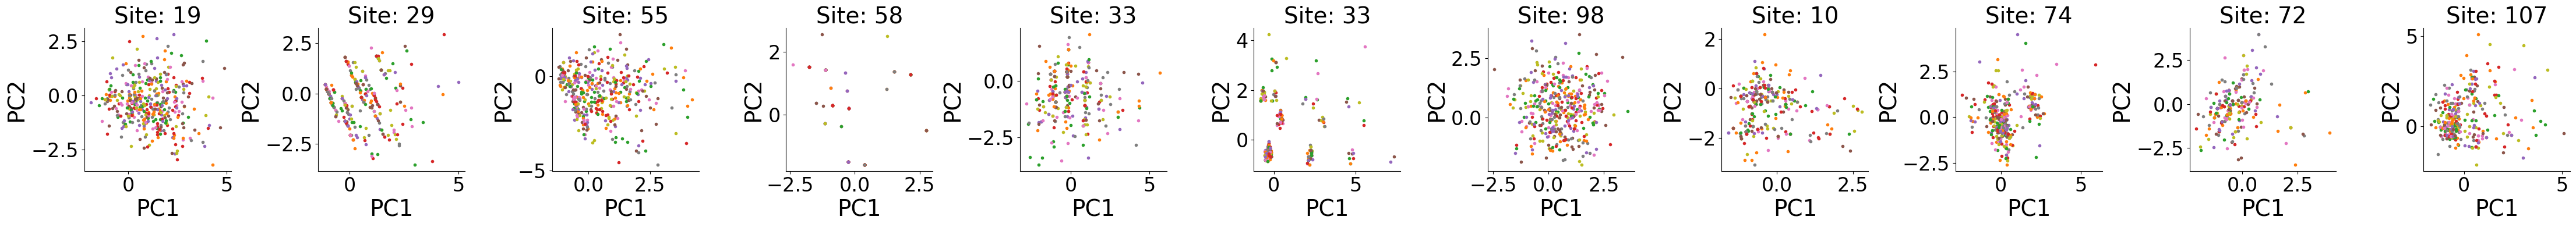

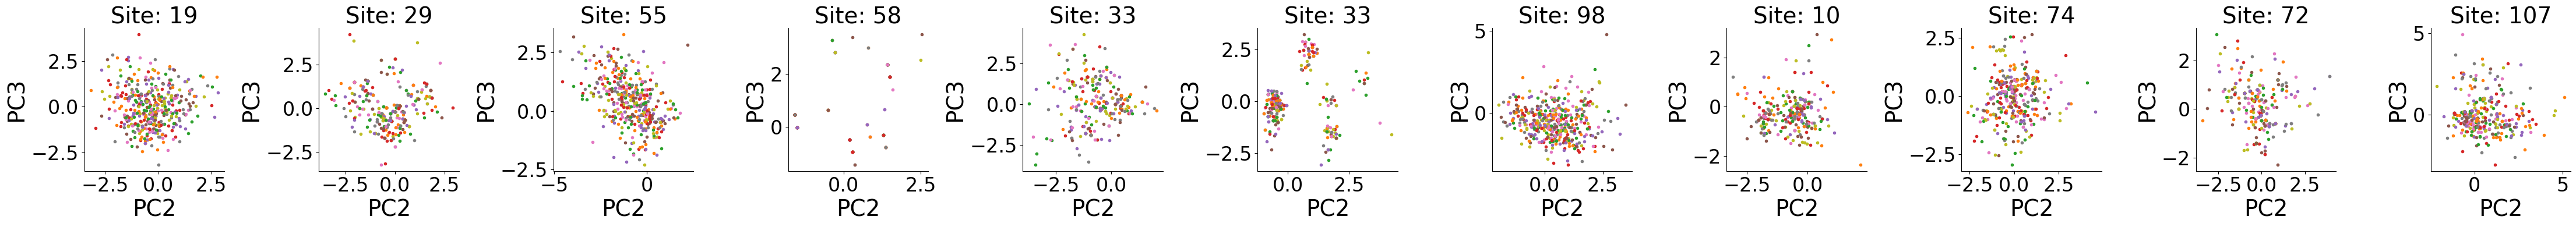

In [32]:
# Plot points at target onset
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,4))
for irec in range(nrecs):
    temp_target_labels = np.array(df['target_idx'][(df['date']==dates[irec])*df['good_trial']])
    temp_pt_idxs = np.array(df['delay_start_neural_idx'][(df['date']==dates[irec])*df['good_trial']]).astype(int)
    for itrial in range(len(temp_target_labels)):
        temp_proj_trial = zconc_pca[irec].transform(zconc_spikes_trial_sep[irec][itrial][:,stable_unit_idx[irec]])
        ax[irec].plot(temp_proj_trial[temp_pt_idxs[itrial],0], temp_proj_trial[temp_pt_idxs[itrial],1],'.', color=colors[temp_target_labels[itrial]])
        ax[irec].set(xlabel='PC1', ylabel='PC2', title=f"Site: {recording_site[irec]}")
fig.tight_layout()
plt.show()

# Plot points at target onset
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,4))
for irec in range(nrecs):
    temp_target_labels = np.array(df['target_idx'][(df['date']==dates[irec])*df['good_trial']])
    temp_pt_idxs = np.array(df['delay_start_neural_idx'][(df['date']==dates[irec])*df['good_trial']]).astype(int)
    for itrial in range(len(temp_target_labels)):
        temp_proj_trial = zconc_pca[irec].transform(zconc_spikes_trial_sep[irec][itrial][:,stable_unit_idx[irec]])
        ax[irec].plot(temp_proj_trial[temp_pt_idxs[itrial],1], temp_proj_trial[temp_pt_idxs[itrial],2],'.', color=colors[temp_target_labels[itrial]])
        ax[irec].set(xlabel='PC2', ylabel='PC3', title=f"Site: {recording_site[irec]}")

fig.tight_layout()
plt.show()

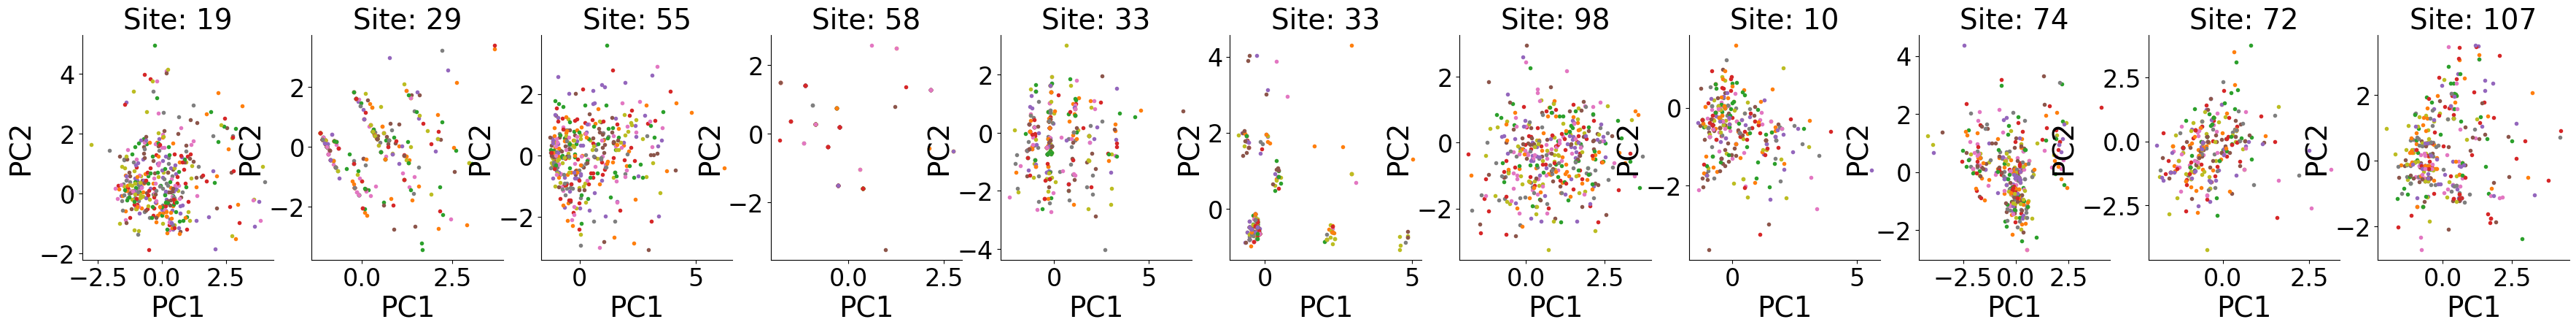

In [33]:
# Plot points at go cue
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,4))
for irec in range(nrecs):
    temp_target_labels = np.array(df['target_idx'][(df['date']==dates[irec])*df['good_trial']])
    temp_pt_idxs = np.array(df['go_cue_neural_idx'][(df['date']==dates[irec])*df['good_trial']]).astype(int)
    for itrial in range(len(temp_target_labels)):
        temp_proj_trial = zconc_pca[irec].transform(zconc_spikes_trial_sep[irec][itrial][:,stable_unit_idx[irec]])
        ax[irec].plot(temp_proj_trial[temp_pt_idxs[itrial],0], temp_proj_trial[temp_pt_idxs[itrial],1],'.', color=colors[temp_target_labels[itrial]])
        ax[irec].set(xlabel='PC1', ylabel='PC2', title=f"Site: {recording_site[irec]}")

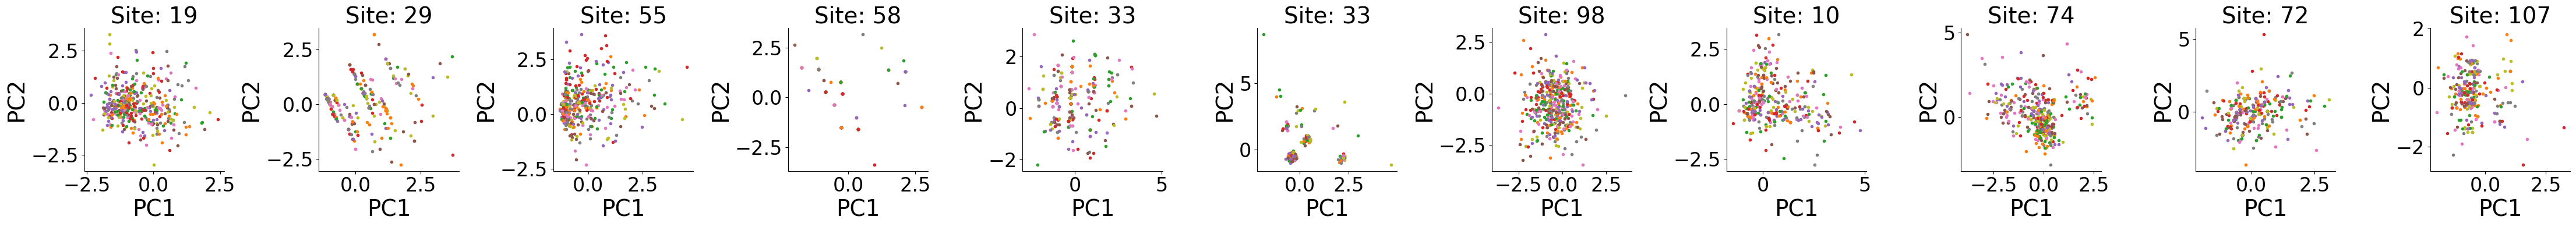

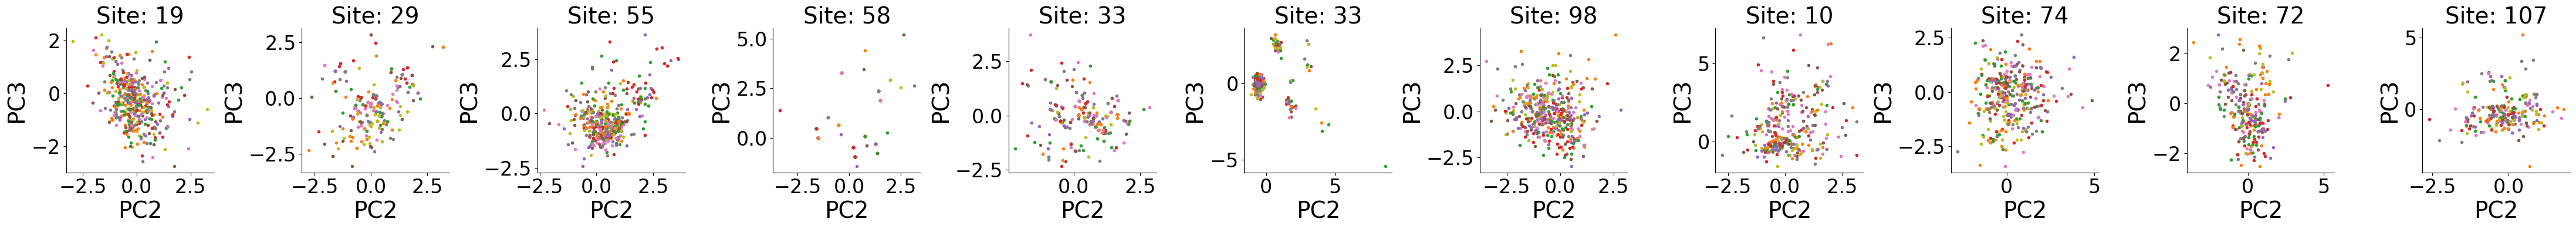

In [34]:
# Plot points at movement onset
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,4))
for irec in range(nrecs):
    temp_target_labels = np.array(df['target_idx'][(df['date']==dates[irec])*df['good_trial']])
    temp_pt_idxs = np.array(df['mov_onset_neural_idx'][(df['date']==dates[irec])*df['good_trial']]).astype(int)
    for itrial in range(len(temp_target_labels)):
        
        temp_proj_trial = zconc_pca[irec].transform(zconc_spikes_trial_sep[irec][itrial][:,stable_unit_idx[irec]])
        ax[irec].plot(temp_proj_trial[temp_pt_idxs[itrial],0], temp_proj_trial[temp_pt_idxs[itrial],1],'.', color=colors[temp_target_labels[itrial]])
        ax[irec].set(xlabel='PC1', ylabel='PC2', title=f"Site: {recording_site[irec]}")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,4))
for irec in range(nrecs):
    temp_target_labels = np.array(df['target_idx'][(df['date']==dates[irec])*df['good_trial']])
    temp_pt_idxs = np.array(df['mov_onset_neural_idx'][(df['date']==dates[irec])*df['good_trial']]).astype(int)
    for itrial in range(len(temp_target_labels)):
        
        temp_proj_trial = zconc_pca[irec].transform(zconc_spikes_trial_sep[irec][itrial][:,stable_unit_idx[irec]])
        ax[irec].plot(temp_proj_trial[temp_pt_idxs[itrial],1], temp_proj_trial[temp_pt_idxs[itrial],2],'.', color=colors[temp_target_labels[itrial]])
        ax[irec].set(xlabel='PC2', ylabel='PC3', title=f"Site: {recording_site[irec]}")
fig.tight_layout()
plt.show()

## Subspace alignment

In [48]:
def compute_CCA(La, Lb):
    '''
    Implemented as described in Gallego 2020 (10.1038/s41593-019-0555-4)
    Args:
        La (ntime, nfeature): Latent dynamics from data A
        Lb (ntime, nfeature): Latent dynamics from data B
    '''
    # Compute Qr decomp to extract the orthonormal basis for the column vectors in the latent dynamics
    Qa, Ra = np.linalg.qr(La)
    Qb, Rb = np.linalg.qr(Lb)

    # Take inner product and perform SVD to get new manifold directions and correlations (S provdes the correlations)
    U, S, V = np.linalg.svd(Qa.T @ Qb)

    # Compute new manifold directions (Ma, Mb)
    Ma = np.linalg.pinv(Ra) @ U
    Mb = np.linalg.pinv(Rb) @ V

    return Ma, Mb, S

def calc_task_rel_dims(neural_data, kin_data, conc_proj_data=False, regularization=None, alpha=1):
    '''
    Calculates the task relevant dimensions by regressing neural activity against kinematic data using least squares.
    If the input neural data is 3D, all trials will be concatenated to calculate the subspace. 
    Calculation is based on the approach used in Sun et al. 2022 https://doi.org/10.1038/s41586-021-04329-x
    
    .. math::
    
        R \\in \\mathbb{R}^{nt \\times nch}
        M \\in \\mathbb{R}^{nt \\times nkin}
        \\beta \\in \\mathbb{R}^{nch \\times nkin}
        R = M\\beta^T
        [\\beta_0 \beta_x \beta_y]^T = (M^T M)^{-1} M^T R

    Args:
        neural_data ((nt, nch) or list of (nt, nch)): Input neural data (:math:`R`) to regress against kinematic activity.
        kin_data ((nt, ndim) or list of (nt, ndim)): Kinematic variables (:math:`M`), commonly position or instantaneous velocity. 'ndims' refers to the number of physical dimensions that define the kinematic data (i.e. X and Y)
        conc_proj_data (bool): If the projected neural data should be concatenated.

    Returns:
        tuple: Tuple containing:
            | **(nch, ndim):** Subspace (:math:`\beta`) that best predicts kinematic variables. Note the first column represents the intercept, then the next dimensions represent the behvaioral variables
            | **((nt, nch) or list of (nt, ndim)):** Neural data projected onto task relevant subspace

    '''

    # If a list of segments from trials, concatenate them into one larget timeseries
    if type(neural_data) == list:
        ntrials = len(neural_data)
        min_time_per_trial = [np.min([len(neural_data[itrial]), len(kin_data[itrial])]) for itrial in range(ntrials)]
        
        conc_neural_data = np.vstack([neural_data[itrial][:min_time_per_trial[itrial]] for itrial in range(ntrials)]) #(nt, nch)
        conc_kin_data_baseline = np.vstack([kin_data[itrial][:min_time_per_trial[itrial]] for itrial in range(ntrials)])
        if conc_neural_data.shape[0] != conc_kin_data_baseline.shape[0]:
            print(f"Neural and kinematic data sizes are {np.abs(conc_neural_data.shape[0]-conc_kin_data_baseline.shape[0])} samples apart")
        
        ntime = np.min([conc_neural_data.shape[0], conc_kin_data_baseline.shape[0]])
        
        # Set input neural data as a float
        conc_neural_data = conc_neural_data.astype(float)[:ntime,:]

        conc_kin_data = np.ones((ntime,kin_data[0].shape[1]+1))*np.nan
        conc_kin_data[:,0] = 1
        conc_kin_data[:,1:] = conc_kin_data_baseline

        # Center neural data:
        conc_neural_data -= np.nanmean(conc_neural_data, axis=0)

        # Calculate task relevant subspace 
        # task_subspace = np.linalg.pinv(conc_kin_data.T @ conc_kin_data) @ conc_kin_data.T @ conc_neural_data
        if regularization is None:        
            # task_subspace = np.linalg.pinv(conc_neural_data.T @ conc_neural_data) @ conc_neural_data.T @ conc_kin_data
            lin_reg_model = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(conc_neural_data, conc_kin_data)
            task_subspace = (lin_reg_model.coef_).T
        elif regularization == 'lasso':
            lasso_model = sklearn.linear_model.Lasso(alpha=alpha, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (lasso_model.coef_).T
        elif regularization == 'ridge':
            ridge_model = sklearn.linear_model.Ridge(alpha=alpha, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (ridge_model.coef_).T
        elif regularization == 'elastic net':
            elasticnet_model = sklearn.linear_model.ElasticNet(alpha=alpha, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (elasticnet_model.coef_).T
    
    else:
        # Save original neural data as a list
        neural_data = [neural_data]
        
        # Set input neural data as a float
        neural_data_centered = neural_data[0].astype(float)
        
        # Center neural data:
        neural_data_centered -= np.nanmean(neural_data_centered, axis=0)
        ntime = neural_data_centered.shape[0]
        conc_kin_data = np.ones((ntime, kin_data.shape[1]+1))*np.nan
        conc_kin_data[:,0] = 1
        conc_kin_data[:,1:] = kin_data
        
        # Calculate task relevant subspace 
        if regularization is None:
            task_subspace = np.linalg.pinv(neural_data_centered.T @ neural_data_centered) @ neural_data_centered.T @ conc_kin_data
        elif regularization == 'lasso':
            lasso_model = sklearn.linear_model.Lasso(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data)
            task_subspace = (lasso_model.coef_).T
        elif regularization == 'ridge':
            ridge_model = sklearn.linear_model.Ridge(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data)
            task_subspace = (ridge_model.coef_).T
        elif regularization == 'elastic net':
            elasticnet_model = sklearn.linear_model.ElasticNet(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data)
            task_subspace = (elasticnet_model.coef_).T
        ntrials = 1
        
    # Project neural data onto task subspace
    projected_data = []
    
    for itrial in range(ntrials):
        projected_data.append(neural_data[itrial] @ task_subspace)

    if conc_proj_data:
        return task_subspace, np.vstack(projected_data)
    else:    
        return task_subspace, projected_data

In [49]:
tavg_time = .5 #[s]
# neural_onset_idx_labels = ['delay_start_neural_idx', 'go_cue_neural_idx', 'mov_onset_neural_idx']
# kin_onset_idx_labels = ['delay_start_kin_idx', 'go_cue_kin_idx', 'mov_onset_kin_idx']
neural_onset_idx_labels = 'mov_onset_neural_idx'
kin_onset_idx_labels = 'mov_onset_kin_idx'


for idate, date in enumerate(tqdm(dates)):
    neural_idx_start = int(preproc_metadata['tbefore']*preproc_metadata['neural_samplerate'])
    neural_idx_stop = int((tavg_time*preproc_metadata['neural_samplerate'])) + neural_idx_start        
    neural_data = rasters['neural'][align_event][idate][neural_idx_start:neural_idx_stop,np.array(df['good_trial'][df['date']==date])][:,:,stable_unit_idx[idate]]

    kin_idx_start = int(preproc_metadata['tbefore']*preproc_metadata['kin_samplerate'])
    kin_idx_stop = int((tavg_time*preproc_metadata['kin_samplerate'])) + kin_idx_start
    kin_data = rasters['cursor_velo'][align_event][idate][kin_idx_start:kin_idx_stop,np.array(df['good_trial'][df['date']==date])]
    hand_data = rasters['hand_velo'][align_event][idate][kin_idx_start:kin_idx_stop,np.array(df['good_trial'][df['date']==date])]

    # test = calc_task_rel_dims(neural_data, kin_data, conc_proj_data=False, regularization=None, alpha=1)
    # scores, test_move_tavg, test_pred_move_tavg, subspace =  xval_task_rel_dims(neural_data, kin_data, labels=np.array(df['target_idx'][(df['date']==date)*df['good_trial']])  ,regularization=None, nfolds=4, alpha=1, smooth_neural_data=False, tavg_neural_data=False, return_test_label_idx=False)
    # scores_hand, test_move_tavg_hand, test_pred_move_tavg_hand, subspace_hand, test_label_idx_hand =  xval_task_rel_dims(neural_data, hand_data, labels=np.array(df['target_idx'][(df['date']==date)*df['good_trial']])  ,regularization=None, nfolds=4, alpha=1, smooth_neural_data=False, tavg_neural_data=True, return_test_label_idx=True)

    

  0%|          | 0/11 [00:00<?, ?it/s]

In [50]:
# print(neural_data.shape)
# print(kin_data.shape)
# print(len(test_pred_move_tavg))
# print(test_pred_move_tavg[0].shape)

In [51]:
# Compute CCs the same way as Gallego paper
proj_data = []
proj_trd_data = []
centered_data = []
# for irec in range(nrecs):
for idate, date in enumerate(tqdm(dates)):
    prep_data = smooth_timeseries_gaus(np.sqrt(np.vstack(frs[align_event]['align_spikes_dwns'][idate]) + 0.375), new_bin_fs, 150) 
    proj_data.append(PCA().fit_transform(prep_data))
    # centered_prep_data = (prep_data.reshape(frs[align_event]['align_spikes_dwns'][irec].shape) - np.mean(prep_data.reshape(frs[align_event]['align_spikes_dwns'][irec].shape), axis=(0,1)))/np.std(prep_data.reshape(frs[align_event]['align_spikes_dwns'][irec].shape), axis=(0,1))
    # centered_data.append(PCA().fit_transform(smooth_timeseries_gaus(np.sqrt(np.vstack(centered_prep_data) + 0.375), new_bin_fs, 150) ))
    
    
    neural_idx_start = int(preproc_metadata['tbefore']*preproc_metadata['neural_samplerate'])
    neural_idx_stop = int((tavg_time*preproc_metadata['neural_samplerate'])) + neural_idx_start        
    neural_data = rasters['neural'][align_event][idate][neural_idx_start:neural_idx_stop,np.array(df['good_trial'][df['date']==date])][:,:,stable_unit_idx[idate]]

    kin_idx_start = int(preproc_metadata['tbefore']*preproc_metadata['kin_samplerate'])
    kin_idx_stop = int((tavg_time*preproc_metadata['kin_samplerate'])) + kin_idx_start
    kin_data = rasters['cursor_velo'][align_event][idate][kin_idx_start:kin_idx_stop,np.array(df['good_trial'][df['date']==date])]
    hand_data = rasters['hand_velo'][align_event][idate][kin_idx_start:kin_idx_stop,np.array(df['good_trial'][df['date']==date])]

    proj_trd_data.append(calc_task_rel_dims(prep_data, np.vstack(kin_data)[::10,:], conc_proj_data=False, regularization=None, alpha=1)[1][0])
    # proj_trd_data.append(calc_task_rel_dims(prep_data, kin_data, conc_proj_data=False, regularization=None, alpha=1)[1])
    
    

  0%|          | 0/11 [00:00<?, ?it/s]

### PC projection alignment

In [52]:
recording_site_M1 = [isite for isite in recording_site if isite in recording_brain_areas['M1']]
recording_site_PM = [isite for isite in recording_site if isite in recording_brain_areas['PM']]
nrecs_M1 = len(recording_site_M1)
nrecs_PM = len(recording_site_PM)

In [53]:
npcs = 3
ccs = np.zeros((nrecs, nrecs, npcs))*np.nan
ccs_trd = np.zeros((nrecs, nrecs, npcs))*np.nan
np_acc_arg_sort = np.argsort(max_np_decoding)
# np_acc_arg_sort = np.arange(nrecs)
for irec in tqdm(range(nrecs)):
    for irec2 in range(nrecs):
        # if proj_data[irec].shape[1] >= 5 and proj_data[irec2].shape[1] >=5:
        for ipc in range(npcs):
            # Ma, Mb, S = compute_CCA(np.vstack(np.swapaxes(rotations[np_acc_arg_sort[irec]][1], 1,2)), np.vstack(np.swapaxes(rotations[np_acc_arg_sort[irec2]][1], 1,2)))
            Ma, Mb, S = compute_CCA(proj_data[irec], proj_data[irec2])
            ccs[irec,irec2,:] =S[:npcs]
            
            Ma_trd, Mb_trd, S_trd = compute_CCA(proj_trd_data[irec], proj_trd_data[irec2])
            ccs_trd[irec,irec2,:] =S_trd[:npcs]

  0%|          | 0/11 [00:00<?, ?it/s]

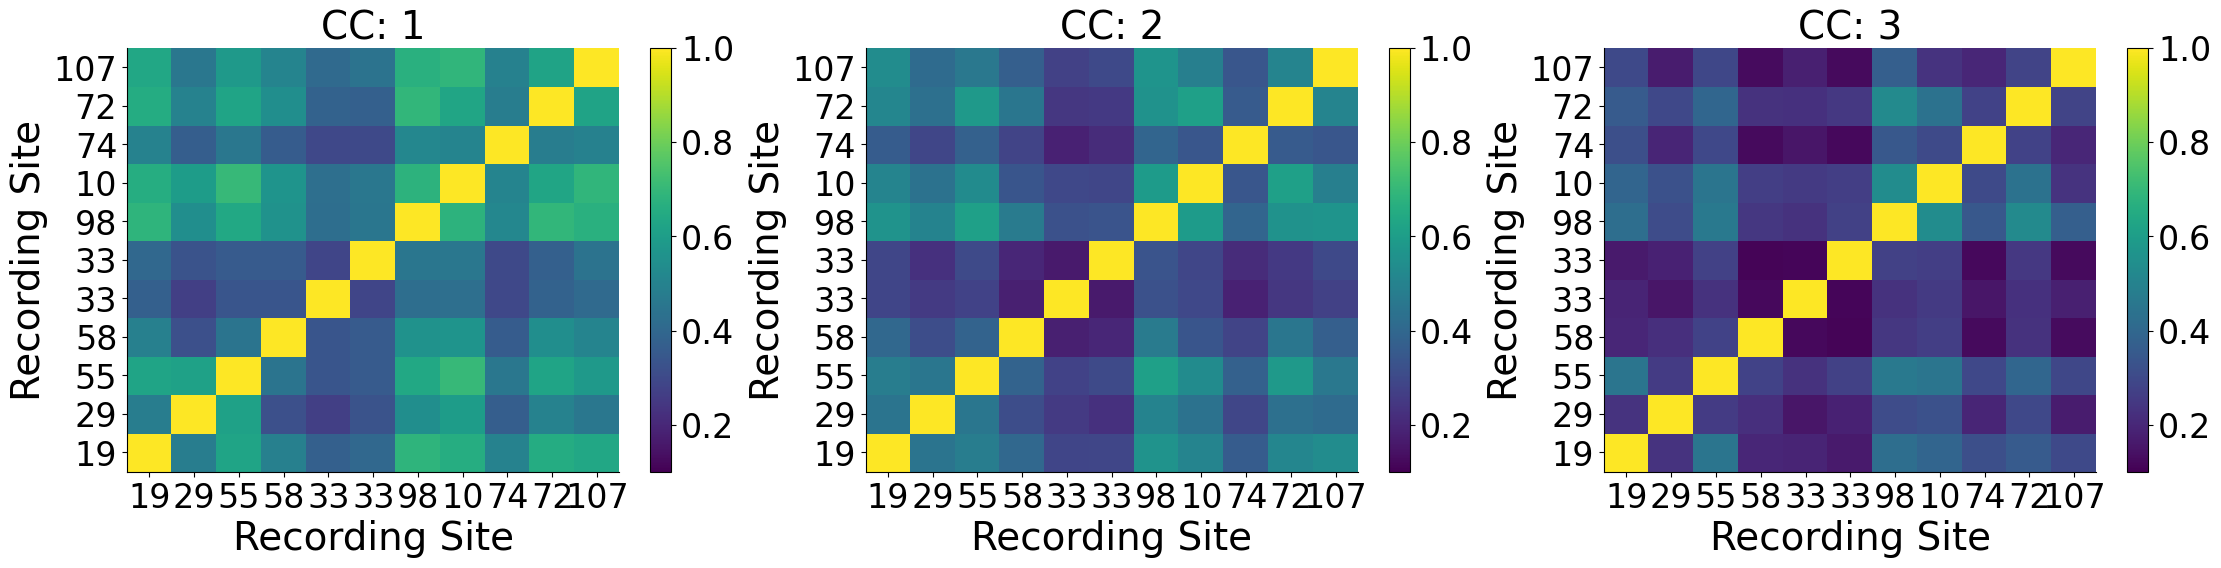

In [54]:
fig, ax = plt.subplots(1, npcs, figsize=(npcs*9, 5.5))
for ipc in range(npcs):
    im = ax[ipc].pcolor(ccs[:,:,ipc], vmin=0.1, vmax=1)
    cb = plt.colorbar(im)
    ax[ipc].set_xticks(np.arange(nrecs)+0.5, recording_site)
    ax[ipc].set_yticks(np.arange(nrecs)+0.5, recording_site)
    ax[ipc].set(xlabel='Recording Site', ylabel='Recording Site', title=f"CC: {ipc+1}")

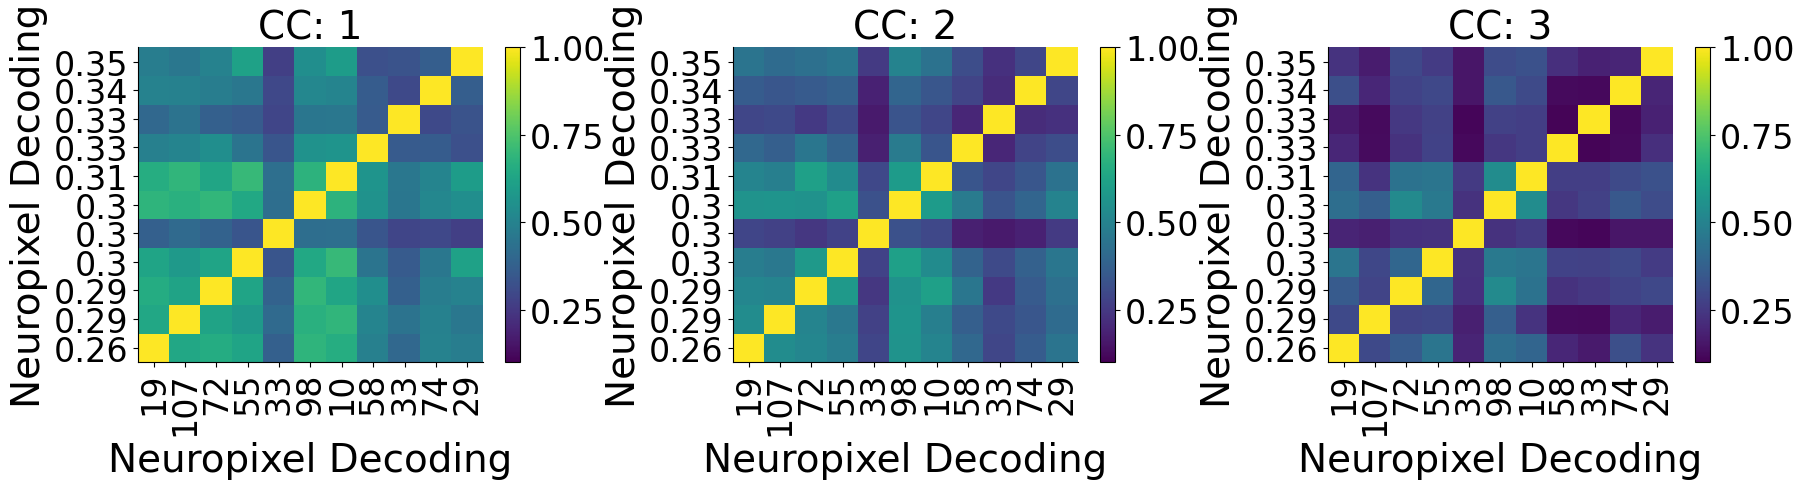

In [55]:
fig, ax = plt.subplots(1, npcs, figsize=(npcs*6, 5))
for ipc in range(npcs):
    im = ax[ipc].pcolor(ccs[np_acc_arg_sort,:,:][:,np_acc_arg_sort,ipc], vmin=0.1, vmax=1)
    cb = plt.colorbar(im)
    ax[ipc].set_xticks(np.arange(nrecs)+0.5, recording_site[np_acc_arg_sort], rotation = 90)
    ax[ipc].set_yticks(np.arange(nrecs)+0.5, np.round(np.array(max_np_decoding)[np_acc_arg_sort], 2))
    ax[ipc].set(xlabel='Neuropixel Decoding', ylabel='Neuropixel Decoding', title=f"CC: {ipc+1}")
    
fig.tight_layout()
plt.show()

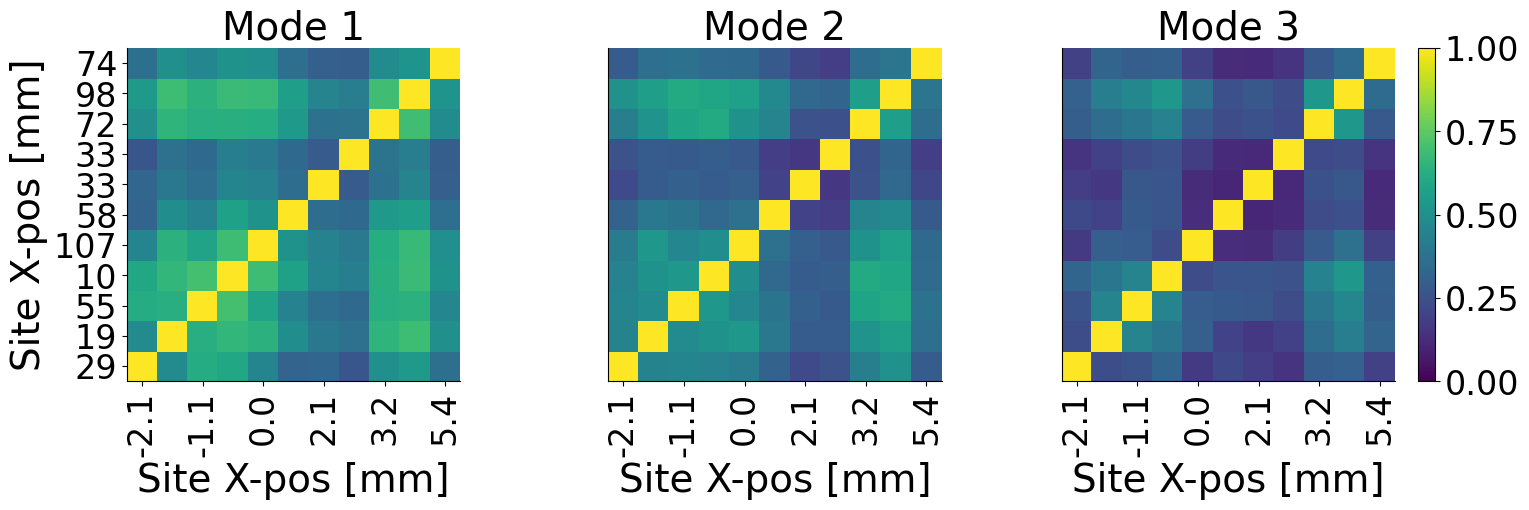

In [56]:
# Sort by caudal to rostral
cr_sort = np.argsort(ecog_dec_acc[subject]['rc_axis'][:,0])
# cr_sort = cr_sort[np.logical_and(cr_sort != 0, cr_sort!=3)]
fig, ax = plt.subplots(1, npcs, figsize=(16.,5))
for ipc in range(npcs):
    im = ax[ipc].pcolor(ccs[cr_sort,:,:][:,cr_sort,ipc], vmin=0, vmax=1)
    
    # ax[ipc].set_yticks(np.arange(nrecs)+0.5, recording_site[cr_sort], rotation = 30)
    ax[ipc].set_xticks(np.arange(len(cr_sort), step=2)+0.5, np.round(ecog_dec_acc[subject]['rc_axis'][:,0][cr_sort][::2], 1), rotation = 90)
    # ax[ipc].set_xticks(np.arange(len(cr_sort), step=2)+0.5, np.arange(np.sum(mask),step=2)+1)
    ax[ipc].set_yticks([],[])
    ax[ipc].set(xlabel='Site X-pos [mm]',  title=f"Mode {ipc+1}")
    ax[ipc].set_aspect('equal')
    
    if ipc == 0:
        ax[ipc].set_ylabel('Site X-pos [mm]')
        # ax[ipc].set_yticks(np.arange(np.sum(mask), step=2)+0.5, np.arange(np.sum(mask), step=2)+1)
        # ax[ipc].set_yticks(np.arange(len(cr_sort),step=2)+0.5, np.round(ecog_dec_acc[subject]['rc_axis'][:,0][cr_sort][::2], 1))
        ax[ipc].set_yticks(np.arange(nrecs)+0.5, recording_site[cr_sort])
    elif ipc == npcs-1:
        cb = plt.colorbar(im)    
    
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'cc_rostral_caudal.svg')

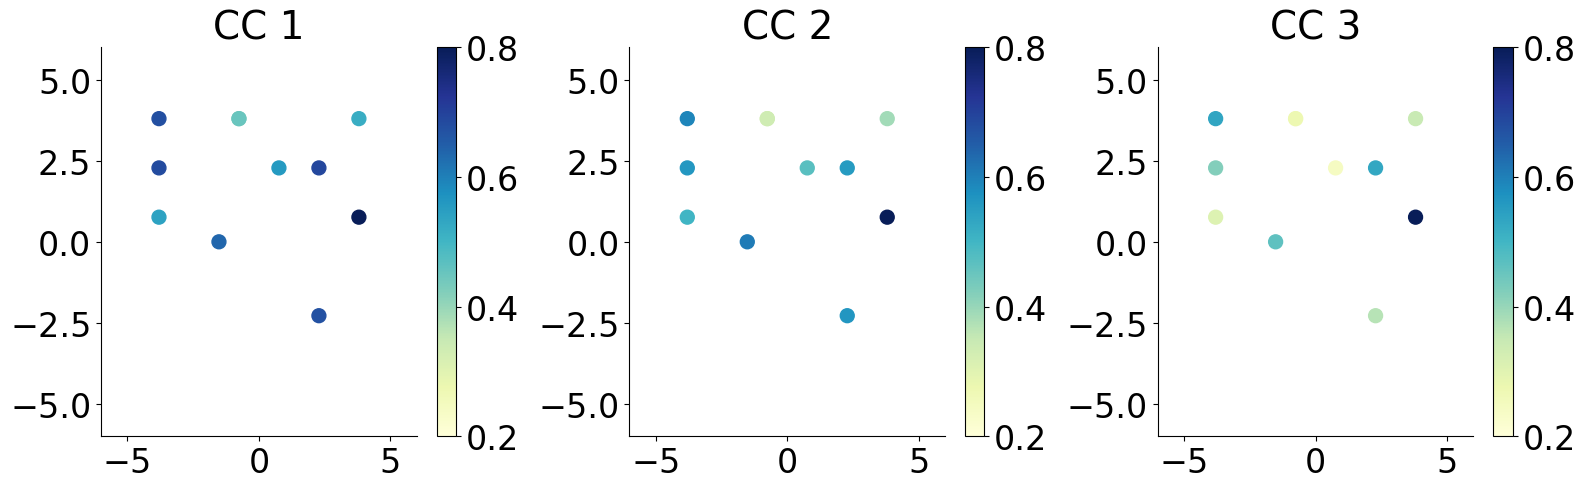

In [57]:
## Plot spatial map of decoding
# ref_site = 107
ref_site = 98
ref_site_idx = np.where(recording_site==ref_site)[0]
fig, ax = plt.subplots(1,npcs,figsize=(16,5))
for ipc in range(npcs):
    colors = ccs[:,ref_site_idx,ipc]
    dec_map = ax[ipc].scatter(ecog_dec_acc[subject]['rec_locations'][:,0], ecog_dec_acc[subject]['rec_locations'][:,1], s=100, c=colors, cmap='YlGnBu', vmin=0.2, vmax=.8)
    cb = plt.colorbar(dec_map)
    ax[ipc].set(xlim=(-6,6), ylim=(-6,6), title=f"CC {ipc+1}")
    
fig.tight_layout()
plt.show()

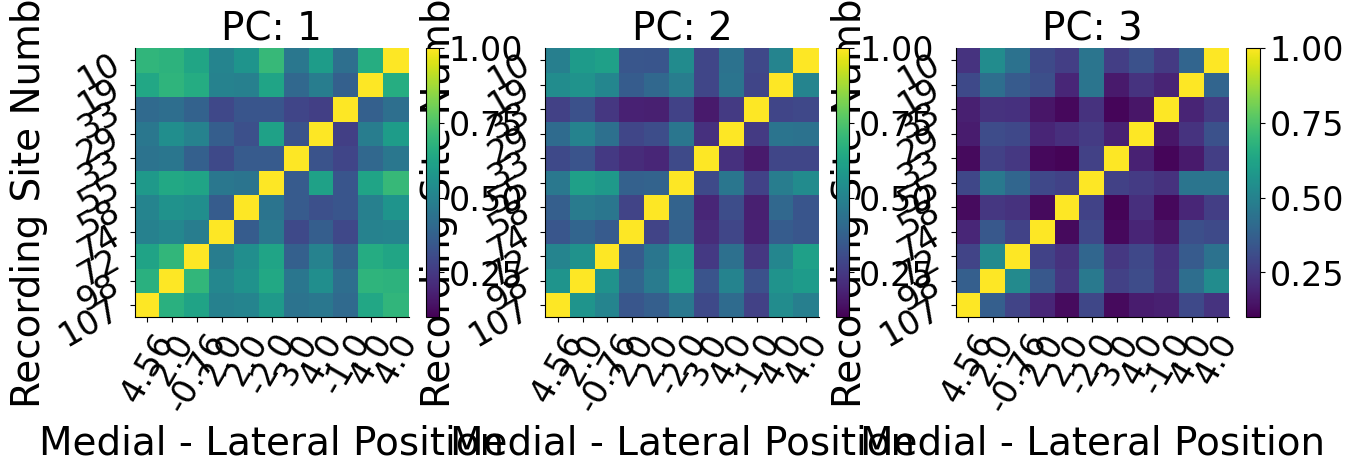

In [73]:
# Sort by medial to lateral
cr_sort = np.argsort(ecog_dec_acc[subject]['rc_axis'][:,1])
fig, ax = plt.subplots(1, npcs, figsize=(npcs*5, 3.5))
for ipc in range(npcs):
    im = ax[ipc].pcolor(ccs[cr_sort,:,:][:,cr_sort,ipc], vmin=0.1, vmax=1)
    cb = plt.colorbar(im)
    ax[ipc].set_yticks(np.arange(nrecs)+0.5, recording_site[cr_sort], rotation = 30)
    ax[ipc].set_xticks(np.arange(nrecs)+0.5, np.round(ecog_dec_acc['beignet']['rec_locations'][:,1][cr_sort], 2), rotation = 60)
    ax[ipc].set(xlabel='Medial - Lateral Position', ylabel='Recording Site Number', title=f"PC: {ipc+1}")

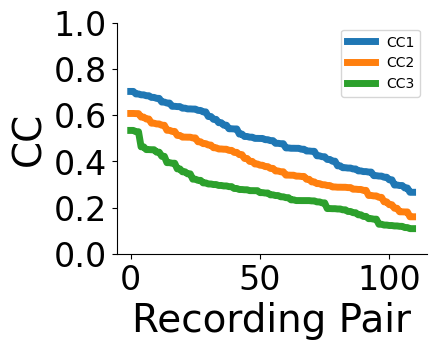

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
for ipc in range(npcs):
    ccs_plt = ccs[:,:,ipc]
    ax.plot(np.flip(np.sort(ccs_plt[ccs_plt<0.999].flatten())))

ax.set(xlabel='Recording Pair', ylabel='CC', ylim=(0,1))
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.legend([f"CC{ipc+1}" for ipc in range(npcs)])
plt.show()

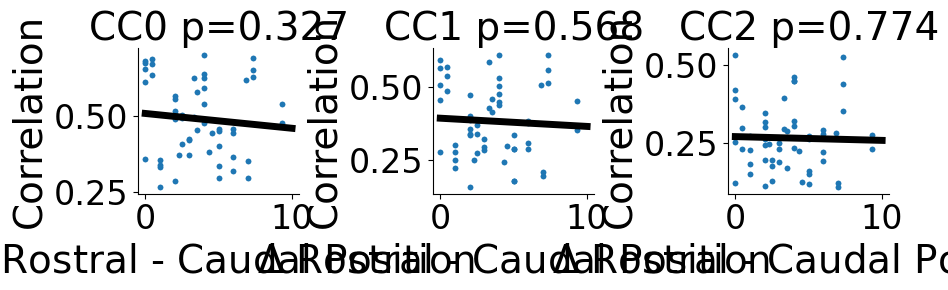

In [60]:
fig, ax = plt.subplots(1,npcs,figsize=(3*npcs,3))
pos_diff = np.zeros((ccs.shape[0], ccs.shape[1]))*np.nan
pos_labels = np.zeros((ccs.shape[0], ccs.shape[1],2))*np.nan
for irec1 in range(ccs.shape[0]):
    for irec2 in range(ccs.shape[1]):
        if irec1 != irec2:
            pos_diff[irec1,irec2] = np.abs(ecog_dec_acc['beignet']['rec_locations'][irec1,0] - ecog_dec_acc['beignet']['rec_locations'][irec2,0])
            pos_labels[irec1,irec2,0] = irec1
            pos_labels[irec1,irec2,1] = irec2
slopes = []
intercepts = []
for ipc in range(npcs):
    nan_mask = ~np.isnan(pos_diff.flatten())
    fit, fitscore, pcc, pval, regfit = aopy.analysis.base.linear_fit_analysis2D(pos_diff.flatten()[nan_mask], ccs[:,:,ipc].flatten()[nan_mask])
    intercept = regfit.intercept_
    intercepts.append(intercept)
    slope = regfit.coef_[0]
    slopes.append(slope)
    ax[ipc].plot(pos_diff.flatten(), ccs[:,:,ipc].flatten(),'.')
    ax[ipc].plot([0,10], [intercept, slope*10 + intercept], 'k')
    ax[ipc].set(xlabel='$\Delta$ Rostral - Caudal Position', ylabel='Correlation', title=f"CC{ipc} p={np.round(pval,3)}")
fig.tight_layout()
plt.show()

In [61]:
# recording_site[8], recording_site[14]
# print(ecog_dec_acc['beignet']['rec_locations'][8,0], ecog_dec_acc['beignet']['rec_locations'][11,0])
# ecog_dec_acc['beignet']['rec_locations'][:,0]

In [62]:
# print(pos_labels[:,:,0].flatten())
# print(pos_labels[:,:,1].flatten())
# print(dec_diff.flatten())
# # print(ccs[:,:,0].flatten())
# ipt = 1
# print(pos_labels[:,:,0].flatten()[ipt] == 0, pos_labels[:,:,1].flatten()[ipt]==1)
# print(pos_labels[:,:,0].flatten()[ipt] == 0 and pos_labels[:,:,1].flatten()[ipt] == 1)
# dec_diff*100

0.05200805062515469
0.039799991737298264
0.007151804390632708


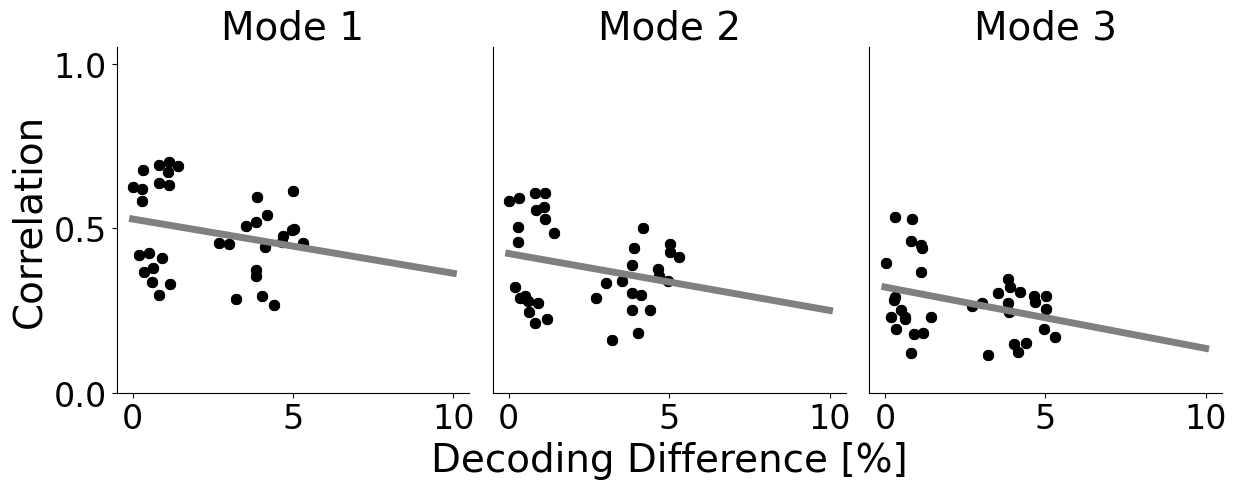

In [63]:
fig, ax = plt.subplots(1,npcs,figsize=(12.5,5))
dec_diff = np.zeros((ccs.shape[0], ccs.shape[1]))*np.nan
for irec1 in range(ccs.shape[0]):
    for irec2 in range(ccs.shape[1]):
        if irec1 != 0 and irec2 != 0 and irec1 != 3 and irec2 != 3 and irec1 != irec2:
            # if irec1 != 3 and irec2 != 3:
            dec_diff[irec1,irec2] = np.abs(max_np_decoding[irec1] - max_np_decoding[irec2]) 

rec1 = 8
rec2 = 11
            
for ipc in range(npcs):
    # ax[ipc].plot(100*dec_diff.flatten(), ccs[:,:,ipc].flatten(),'k.', markersize=10)
    # dec_diff_map = ax[ipc].scatter(100*dec_diff.flatten(), ccs[:,:,ipc].flatten(),s=50, c=(0.75, 0.75, 0.75))
    dec_diff_map = ax[ipc].scatter(100*dec_diff.flatten(), ccs[:,:,ipc].flatten(),s=50, c='black')
    for ipt in range(len(dec_diff.flatten())):
        if pos_labels[:,:,0].flatten()[ipt] == rec1 and pos_labels[:,:,1].flatten()[ipt] == rec2:
            # print(100*dec_diff.flatten()[ipt], ccs[:,:,ipc].flatten()[ipt])
            dec_diff_map = ax[ipc].scatter(100*dec_diff.flatten()[ipt], ccs[:,:,ipc].flatten()[ipt],s=50, c='black')
    
    nan_mask = ~np.isnan(dec_diff.flatten())
    fit, fitscore, pcc, pval, regfit = aopy.analysis.base.linear_fit_analysis2D(100*dec_diff.flatten()[nan_mask], ccs[:,:,ipc].flatten()[nan_mask])
    intercept = regfit.intercept_
    # intercepts.append(intercept)
    slope = regfit.coef_[0]
    # slopes.append(slope)
    print(pval)
    ax[ipc].plot([0,10], [intercept, slope*10 + intercept], color=(0.5, 0.5, 0.5))

    ax[ipc].set_yticks([])
    ax[ipc].set(title=f"Mode {ipc+1}", ylim=(0,1.05))
    if ipc == 0:
        ax[ipc].set_yticks([0,.5,1])
        ax[ipc].set(ylabel='Correlation')
    if ipc == 1:
        ax[ipc].set(xlabel='Decoding Difference [%]')
    # elif ipc == npcs-1:
    #     cb = plt.colorbar(dec_diff_map, label='X-Position \n Difference [mm]')
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'cca_cc_delta_dec.svg')

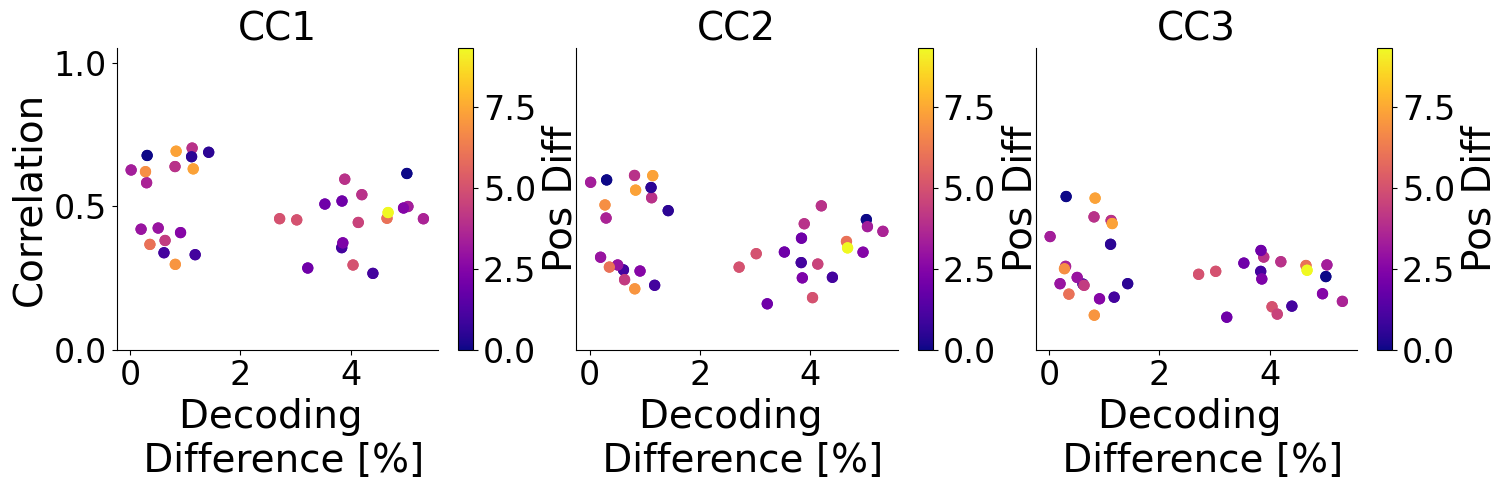

In [64]:
fig, ax = plt.subplots(1,npcs,figsize=(15,5))
dec_diff = np.zeros((ccs.shape[0], ccs.shape[1]))*np.nan
for irec1 in range(ccs.shape[0]):
    for irec2 in range(ccs.shape[1]):
        if irec1 != 0 and irec2 != 0 and irec1 != 3 and irec2 != 3 and irec1 != irec2:
            # if irec1 != 3 and irec2 != 3:
            dec_diff[irec1,irec2] = np.abs(max_np_decoding[irec1] - max_np_decoding[irec2]) 

for ipc in range(npcs):
    # ax[ipc].plot(100*dec_diff.flatten(), ccs[:,:,ipc].flatten(),'k.', markersize=10)
    dec_diff_map = ax[ipc].scatter(100*dec_diff.flatten(), ccs[:,:,ipc].flatten(),s=50, c=pos_diff.flatten(), cmap='plasma')
    cb = plt.colorbar(dec_diff_map, label='Pos Diff')
    ax[ipc].set_yticks([])
    ax[ipc].set(xlabel='Decoding \n Difference [%]', title=f"CC{ipc+1}", ylim=(0,1.05))
    if ipc == 0:
        ax[ipc].set_yticks([0,.5,1])
        ax[ipc].set(ylabel='Correlation')
        
    # elif ipc == npcs-1:
    #     cb = plt.colorbar(dec_diff_map, label='X-Position \n Difference [mm]')
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'cca_cc_delta_dec_colored.svg')

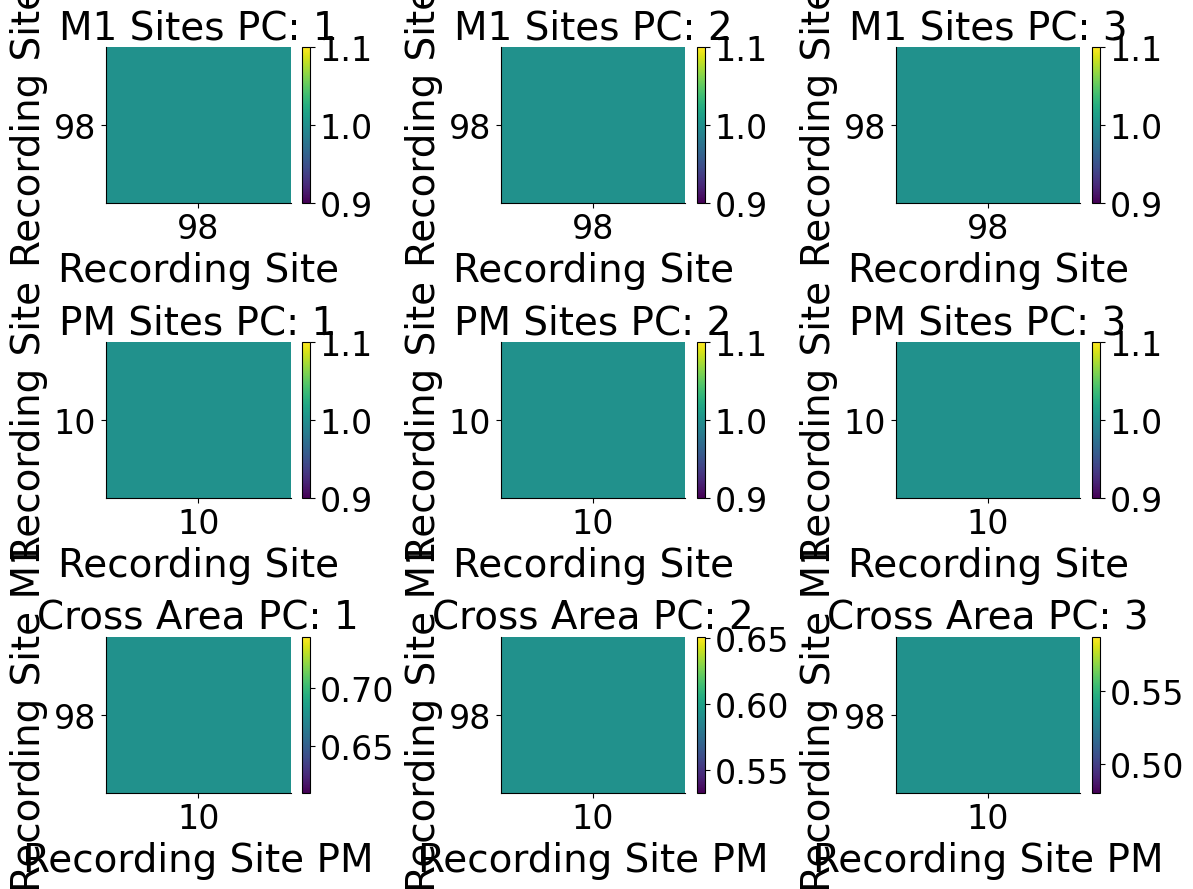

In [65]:
# Extract ccs for sites within each brain area
site_mask_M1 = np.isin(recording_site, recording_brain_areas['M1'])
site_mask_PM = np.isin(recording_site, recording_brain_areas['PM'])

fig, ax = plt.subplots(3, npcs, figsize=(npcs*4, 9))
for ipc in range(npcs):
    im = ax[0,ipc].pcolor(ccs[site_mask_M1, :,ipc][:,site_mask_M1])
    cb = plt.colorbar(im)
    ax[0,ipc].set_xticks(np.arange(np.sum(site_mask_M1))+0.5, recording_site[site_mask_M1])
    ax[0,ipc].set_yticks(np.arange(np.sum(site_mask_M1))+0.5, recording_site[site_mask_M1])
    ax[0,ipc].set(xlabel='Recording Site', ylabel='Recording Site', title=f"M1 Sites PC: {ipc+1}")

    im = ax[1,ipc].pcolor(ccs[site_mask_PM, :,ipc][:,site_mask_PM])
    cb = plt.colorbar(im)
    ax[1,ipc].set_xticks(np.arange(np.sum(site_mask_PM))+0.5, recording_site[site_mask_PM])
    ax[1,ipc].set_yticks(np.arange(np.sum(site_mask_PM))+0.5, recording_site[site_mask_PM])
    ax[1,ipc].set(xlabel='Recording Site', ylabel='Recording Site', title=f"PM Sites PC: {ipc+1}")

    im = ax[2,ipc].pcolor(ccs[site_mask_M1, :,ipc][:,site_mask_PM])
    cb = plt.colorbar(im)
    ax[2,ipc].set_xticks(np.arange(np.sum(site_mask_PM))+0.5, recording_site[site_mask_PM])
    ax[2,ipc].set_yticks(np.arange(np.sum(site_mask_M1))+0.5, recording_site[site_mask_M1])
    ax[2,ipc].set(xlabel='Recording Site PM', ylabel='Recording Site M1', title=f"Cross Area PC: {ipc+1}")

fig.tight_layout()
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

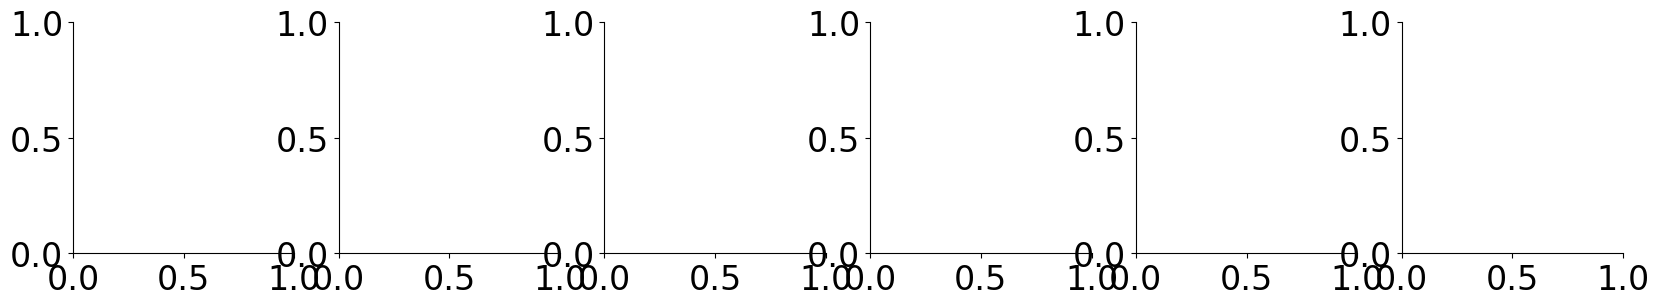

In [66]:
# Project trials onto shared PCs. Compare targeted pairs
fig, ax = plt.subplots(1,6, figsize=(20,3))
ntargets = np.array(rotations[0][0]).shape[2]
smooth_width = 300

# Compare site 11 and 45
irec1 = np.where(recording_site==98)[0][0]
irec2 = np.where(recording_site==45)[0][0]
# Ma, Mb, S = compute_CCA(np.vstack(np.swapaxes(rotations[irec1][1], 1,2)).T, np.vstack(np.swapaxes(rotations[irec2][1], 1,2)).T)
Ma, Mb, S = compute_CCA(proj_data[irec1], proj_data[irec2])
site1_proj_all = []
site2_proj_all = []
for itarget in range(ntargets):
    # site1_proj = np.array(rotations[irec1][0])[:,:,itarget] @ Ma
    # site2_proj = np.array(rotations[irec2][0])[:,:,itarget] @ Mb
    temp_target_labels1 = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec1])])
    temp_target_labels2 = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec2])])
    site1_proj = np.mean(centered_data[irec1][:,temp_target_labels1==(itarget+1),:], axis=1) @ Ma
    site2_proj = np.mean(centered_data[irec2][:,temp_target_labels2==(itarget+1),:], axis=1) @ Mb
    site1_proj_all.append(site1_proj)
    site2_proj_all.append(site2_proj)
    # smooth_timeseries_gaus(rotations[irec][0][:,0,icond], new_bin_fs_rot, smooth_width)
    
    
centered_cc1_site1 = np.array(site1_proj_all)[:,:,0] - np.mean(np.array(site1_proj_all)[:,:,0], axis=0)
centered_cc2_site1 = np.array(site1_proj_all)[:,:,1] - np.mean(np.array(site1_proj_all)[:,:,1], axis=0)
centered_cc1_site2 = np.array(site2_proj_all)[:,:,0] - np.mean(np.array(site2_proj_all)[:,:,0], axis=0)
centered_cc2_site2 = np.array(site2_proj_all)[:,:,1] - np.mean(np.array(site2_proj_all)[:,:,1], axis=0)
# ax[0].plot(smooth_timeseries_gaus(site1_proj[:,0], new_bin_fs, smooth_width), smooth_timeseries_gaus(site1_proj[:,1], new_bin_fs, smooth_width), color=colors[itarget])
# ax[0].plot(smooth_timeseries_gaus(site2_proj[:,0], new_bin_fs, smooth_width), smooth_timeseries_gaus(site2_proj[:,1], new_bin_fs, smooth_width), '--', color=colors[itarget])
for itarget in range(ntargets):
    ax[0].plot(smooth_timeseries_gaus(centered_cc1_site1[itarget,:], new_bin_fs, smooth_width), smooth_timeseries_gaus(centered_cc2_site1[itarget,:], new_bin_fs, smooth_width), color=colors[itarget])
    ax[1].plot(smooth_timeseries_gaus(centered_cc1_site2[itarget,:], new_bin_fs, smooth_width), smooth_timeseries_gaus(centered_cc2_site2[itarget,:], new_bin_fs, smooth_width), '--', color=colors[itarget])

### TRD projection alignment

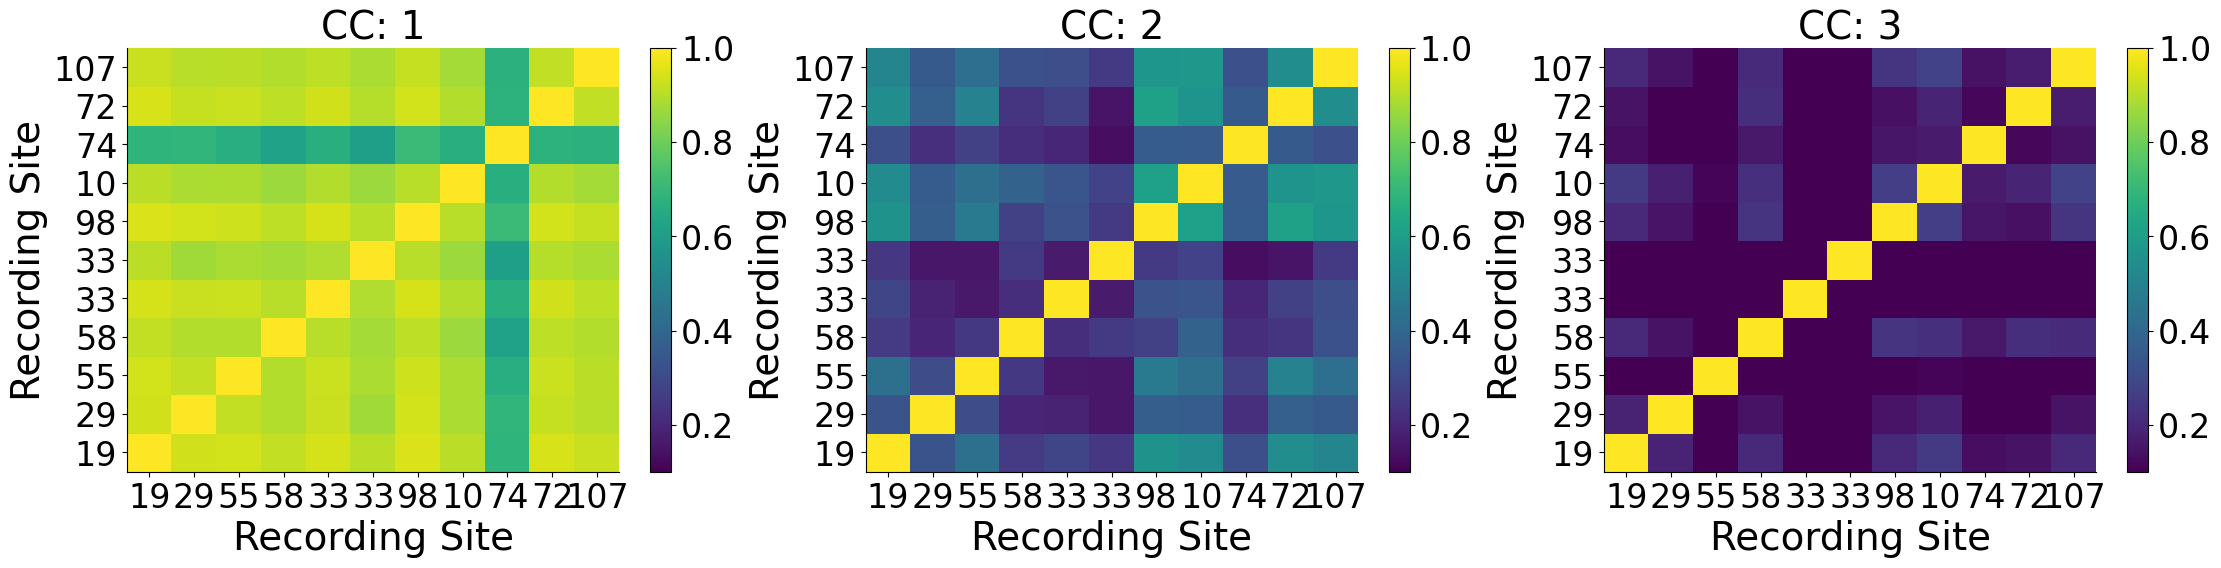

In [67]:
fig, ax = plt.subplots(1, npcs, figsize=(npcs*9, 5.5))
for ipc in range(npcs):
    im = ax[ipc].pcolor(ccs_trd[:,:,ipc], vmin=0.1, vmax=1)
    cb = plt.colorbar(im)
    ax[ipc].set_xticks(np.arange(nrecs)+0.5, recording_site)
    ax[ipc].set_yticks(np.arange(nrecs)+0.5, recording_site)
    ax[ipc].set(xlabel='Recording Site', ylabel='Recording Site', title=f"CC: {ipc+1}")

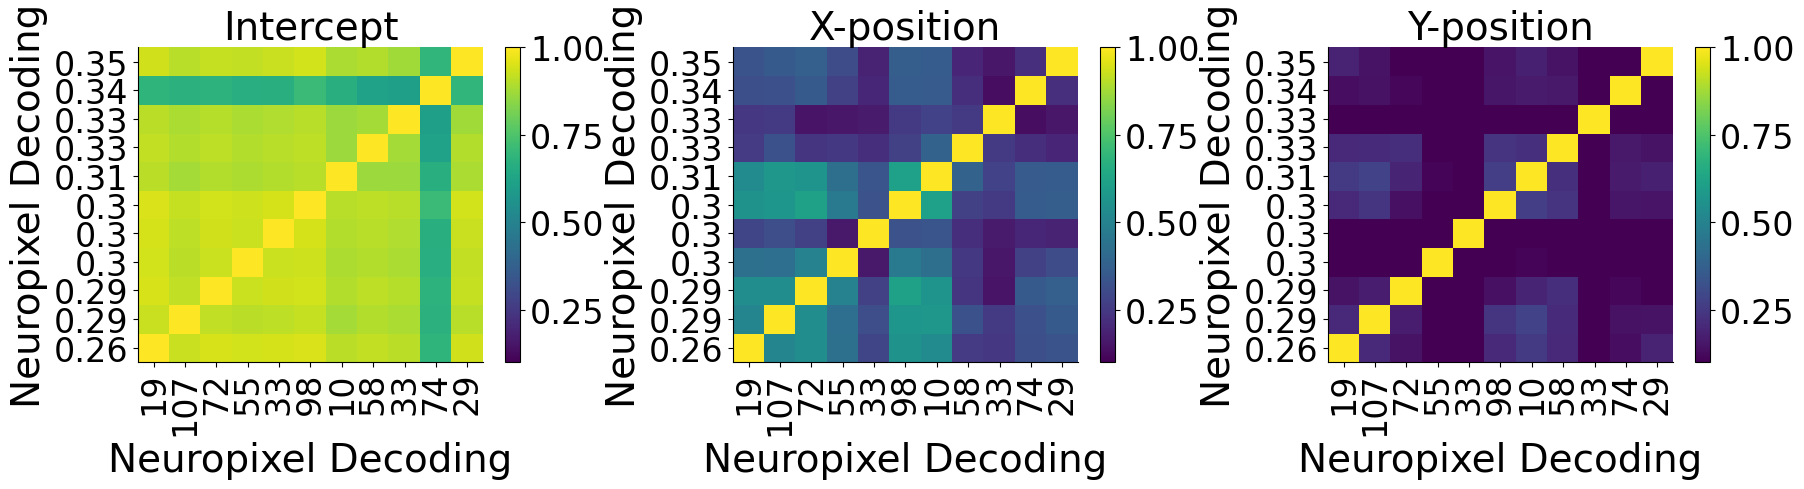

In [70]:
fig, ax = plt.subplots(1, npcs, figsize=(npcs*6, 5))
for ipc in range(npcs):
    im = ax[ipc].pcolor(ccs_trd[np_acc_arg_sort,:,:][:,np_acc_arg_sort,ipc], vmin=0.1, vmax=1)
    cb = plt.colorbar(im)
    ax[ipc].set_xticks(np.arange(nrecs)+0.5, recording_site[np_acc_arg_sort], rotation = 90)
    ax[ipc].set_yticks(np.arange(nrecs)+0.5, np.round(np.array(max_np_decoding)[np_acc_arg_sort], 2))
    ax[ipc].set(xlabel='Neuropixel Decoding', ylabel='Neuropixel Decoding')
    
ax[0].set_title('Intercept'), ax[1].set_title('X-position'), ax[2].set_title('Y-position')
    
fig.tight_layout()
plt.show()

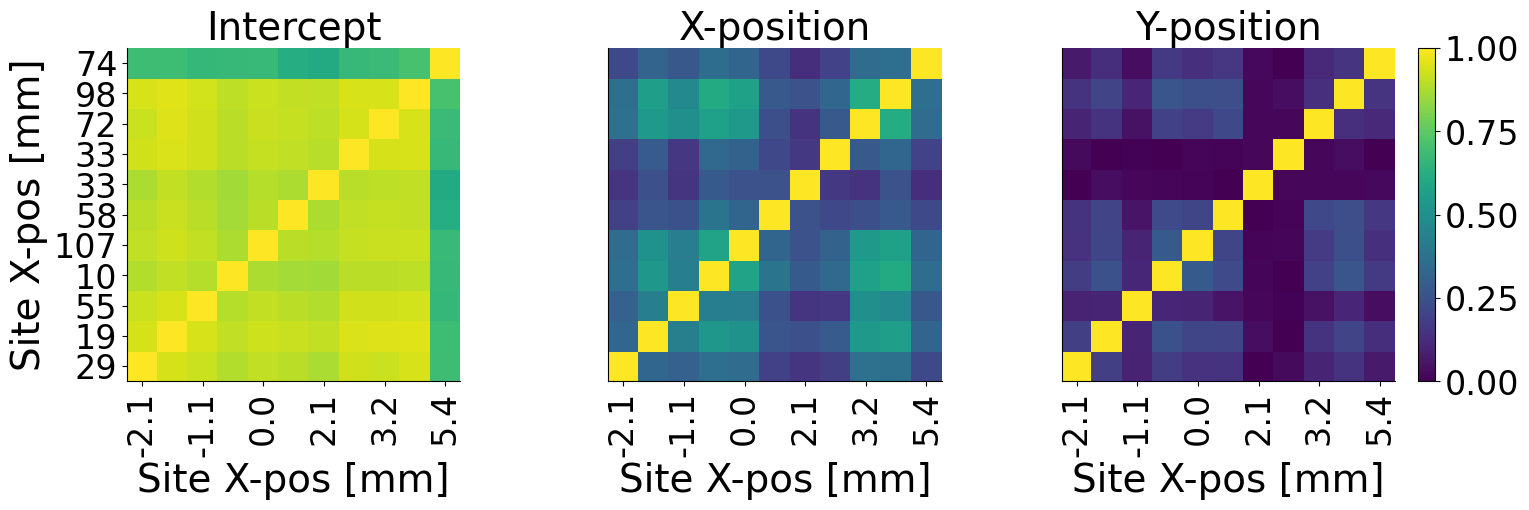

In [72]:
# Sort by caudal to rostral
cr_sort = np.argsort(ecog_dec_acc[subject]['rc_axis'][:,0])
# cr_sort = cr_sort[np.logical_and(cr_sort != 0, cr_sort!=3)]
fig, ax = plt.subplots(1, npcs, figsize=(16.,5))
for ipc in range(npcs):
    im = ax[ipc].pcolor(ccs_trd[cr_sort,:,:][:,cr_sort,ipc], vmin=0, vmax=1)
    
    # ax[ipc].set_yticks(np.arange(nrecs)+0.5, recording_site[cr_sort], rotation = 30)
    ax[ipc].set_xticks(np.arange(len(cr_sort), step=2)+0.5, np.round(ecog_dec_acc[subject]['rc_axis'][:,0][cr_sort][::2], 1), rotation = 90)
    # ax[ipc].set_xticks(np.arange(len(cr_sort), step=2)+0.5, np.arange(np.sum(mask),step=2)+1)
    ax[ipc].set_yticks([],[])
    ax[ipc].set(xlabel='Site X-pos [mm]')
    ax[ipc].set_aspect('equal')
    
    if ipc == 0:
        ax[ipc].set_ylabel('Site X-pos [mm]')
        # ax[ipc].set_yticks(np.arange(np.sum(mask), step=2)+0.5, np.arange(np.sum(mask), step=2)+1)
        # ax[ipc].set_yticks(np.arange(len(cr_sort),step=2)+0.5, np.round(ecog_dec_acc[subject]['rc_axis'][:,0][cr_sort][::2], 1))
        ax[ipc].set_yticks(np.arange(nrecs)+0.5, recording_site[cr_sort])
    elif ipc == npcs-1:
        cb = plt.colorbar(im)    
ax[0].set_title('Intercept'), ax[1].set_title('X-position'), ax[2].set_title('Y-position')
        
fig.tight_layout()
# aopy.visualization.savefig(base_save_dir, f'cc_rostral_caudal.svg')

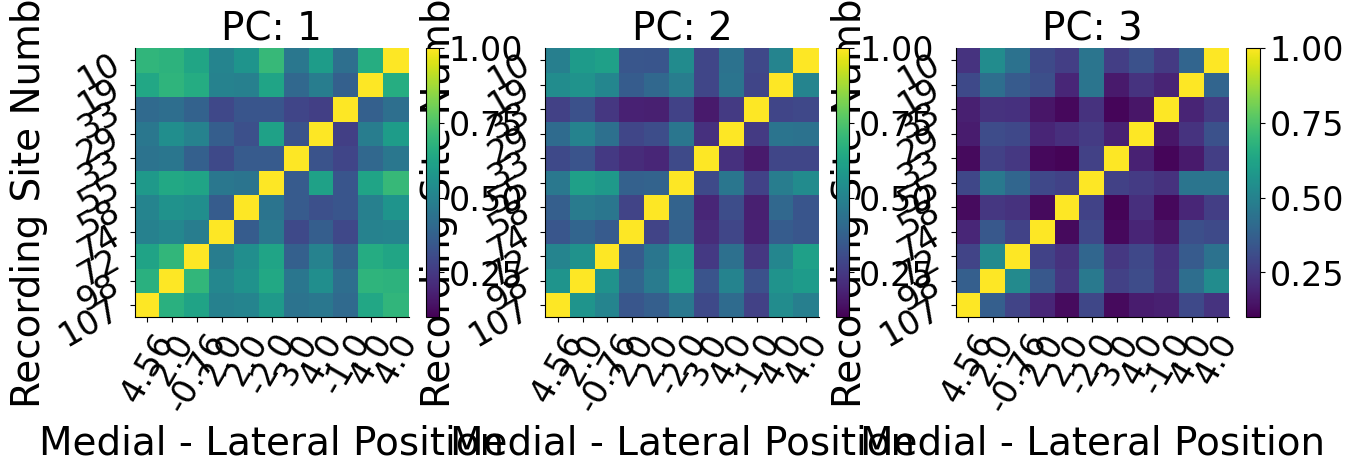

In [74]:
# Sort by medial to lateral
cr_sort = np.argsort(ecog_dec_acc[subject]['rc_axis'][:,1])
fig, ax = plt.subplots(1, npcs, figsize=(npcs*5, 3.5))
for ipc in range(npcs):
    im = ax[ipc].pcolor(ccs[cr_sort,:,:][:,cr_sort,ipc], vmin=0.1, vmax=1)
    cb = plt.colorbar(im)
    ax[ipc].set_yticks(np.arange(nrecs)+0.5, recording_site[cr_sort], rotation = 30)
    ax[ipc].set_xticks(np.arange(nrecs)+0.5, np.round(ecog_dec_acc['beignet']['rec_locations'][:,1][cr_sort], 2), rotation = 60)
    ax[ipc].set(xlabel='Medial - Lateral Position', ylabel='Recording Site Number', title=f"PC: {ipc+1}")

## Decoding in different PCs

In [ ]:
print(colors)

In [ ]:
np.array(site1_proj_all)[:,:,0].shape
np.mean(np.array(site1_proj_all)[:,:,0], axis=0).shape
np.mean(centered_cc1[:,0])